In [ ]:
# To get the lastest pickle files run
! cat pullresults.sh

In [2]:
import warnings
warnings.filterwarnings('ignore') # warnings are for the weak

In [1689]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import re
import sys

import fna

import pipeline as pipeline

sys.path.append("demyelination/") # we need this to successfully read pickle files

In [185]:
def preparedf (dataobjs):
    # input dataframe
    # output organized data
    if len(dataobjs) == 0:
        raise Exception("No activity files found.")

    parts = dataobjs[0].spikeobj.keys()

    df = pd.DataFrame()

    for part in parts:
        for data in dataobjs:
            #data.spikeobj[part].time_offset(250)
            tmp = data.params
            tmp = tmp.update({
                "brainPart" : part,
                "meanSpkRate" : data.spikeobj[part].mean_rate(),
                "pearsonCoeff" : data.metrics['pearsoncoeff'][part],
                "cvIsi" : data.spikeobj[part].cv_isi().mean(),
                "meanBurstSpikePercentageCerina" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part].time_slice(1000, 2000), "cerina" )),
                "meanBurstSpikePercentageMIT" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part].time_slice(2000, 5000), "mit" )),
                #"meanBurstSpikePercentage" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part] ))
            })
            df = df.append(data.params, ignore_index=True)

    return df

In [46]:
def makesubplot (data, fig, ax, attr, varone, vartwo, brainParts, title="", unit=""):
    #varone, vartwo = "nuX_aone", "nuX_th"
    #for axis, part in zip([0, 1], ["MGN", "TRN"]):
    for axis, part in enumerate(brainParts):
        d = data[ data["brainPart"] == part ].pivot_table(attr, varone, vartwo)

        p = ax[axis].imshow(d, interpolation="nearest")
        
        cb = fig.colorbar(p, ax=ax[axis])
        cb.set_label(unit)

        ax[axis].set_title(title + " " + attr + " " + part)

        j = 2
        
        ax[axis].set_yticks(range(0, len(d.index.values), j))
        ax[axis].set_yticklabels(d.index.values[::j])
        
        ax[axis].set_xticks(range(0, len(d.columns.values), j))
        ax[axis].set_xticklabels(d.columns.values[::j])
        
        ax[axis].set_ylabel(varone)
        ax[axis].set_xlabel(vartwo)


In [5]:
def makerasterplot (fls, path, fig, ax):
    for idx, fl in enumerate(fls):
        d = pd.read_pickle(path + fl)

        fig.set_size_inches(50, 9)
        #plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

        for axis, part in zip([0, 1], d.spikeobj.keys()):
            clr = 'red' if part == 'MGN' else 'blue'

            d.spikeobj[part].raster_plot(ax=ax[idx][axis], dt=10, display=False, color=clr)
            ax[idx][axis].set_ylabel(part)
            ax[idx][axis].set_title(fl)

    fig.tight_layout()

In [6]:
def computeBurstSpikeRatio (spiketrain, criterion="cerina"):
    if criterion == "cerina":
        quiettime = 50.
        minspikes = 4.
    elif criterion == "mit":
        quiettime = 100.
        minspikes = 2.
    else:
        raise Exception("Criterion not implemented")
        
    spkdiff = np.diff(spiketrain)

    count = 0
    idx = 1

    while idx < len(spkdiff):
        # was the last spike less than 50ms ago
        if spkdiff[idx-1] <= 100.:
            idx += 1
            continue

        # how many more burst spikes can we find?
        c = 1
        
        # is the next spike within 4ms
        if spkdiff[idx] <= quiettime:
            # how many of the following spikes are within 8ms
            # we need at least 3 more for this to be a burst
            
            try:
                while spkdiff[idx+c] <= 20.:
                    c += 1

                if c >= minspikes:
                    count += c + 1
                    idx += c
                    continue # restart the loop
            except:
                pass
        
        idx += 1

    return 0 if len(spiketrain) == 0 else 100 * count / len(spiketrain)

def computePopulationBurstSpikeRatio (population, criterion="cerina"):
    k = population.spiketrains.keys()
    
    return [computeBurstSpikeRatio(population.spiketrains[_].spike_times, criterion) for _ in k]

#computeBurstSpikeRatio(spk.spikeobj['MGN'].spiketrains[500.0].spike_times)
#computePopulationBurstSpikeRatio(spk.spikeobj['MGN'])

In [7]:
tau = 10.

from fna.tools.signals import make_simple_kernel, pad_array
kernel = make_simple_kernel('exp', tau=tau, width=100., height=1./tau, resolution=1.)

** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.


In [1044]:
def smoothedspikes(spikes):
    tau = 10
    #spikes = spikes.time_slice(0, l)

    kernel = make_simple_kernel('exp', tau=tau, width=100., height=1./tau, resolution=1.)
    axis_, rates = spikes.averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000)
    
    return axis_, rates

## Without Stim

In [379]:
! ls demyelination/data/adaptation-thl-widerange/activity/ | wc -l

10641


In [1164]:
files2 = pipeline.readfiles("demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/");
df = preparedf(files2);

[PIPELINE readfiles] fetching data from folder  demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/
[PIPELINE readfiles] fetched filenames
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_ctx=1.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_ctx=0.05
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_c

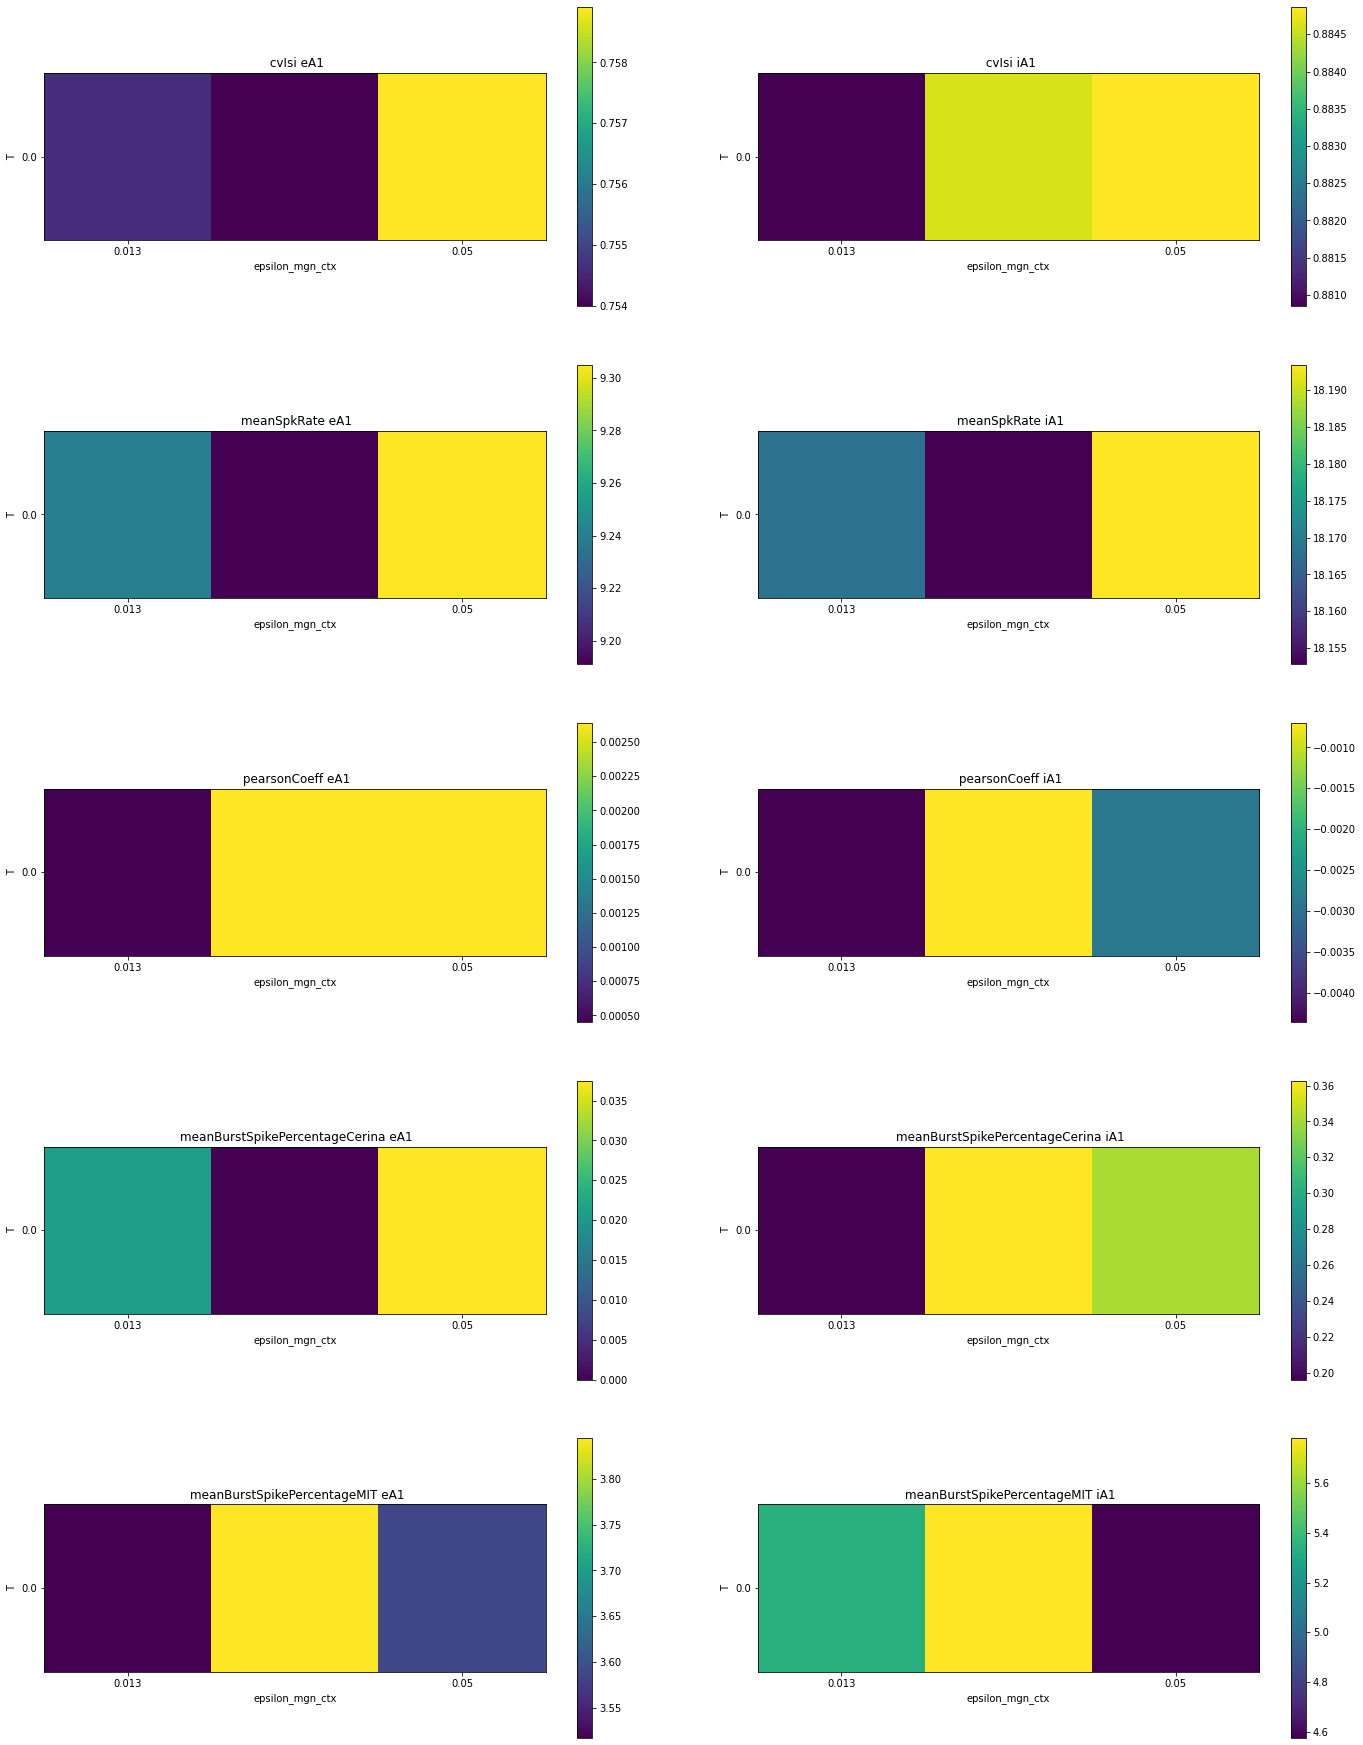

In [910]:
fig, ax = plt.subplots(nrows=5, ncols=2)

fig.set_size_inches(20, 25)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

#dfFilter = df.w_input_aone == 15
dfFilter = [True] * df.shape[0]

makesubplot(df[dfFilter], fig, ax[0], "cvIsi")

makesubplot(df[dfFilter], fig, ax[1], "meanSpkRate")

makesubplot(df[dfFilter], fig, ax[2], "pearsonCoeff")

makesubplot(df[dfFilter], fig, ax[3], "meanBurstSpikePercentageCerina")

makesubplot(df[dfFilter], fig, ax[4], "meanBurstSpikePercentageMIT")

fig.tight_layout()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/adaptation-aone_winputaone=15.pdf")

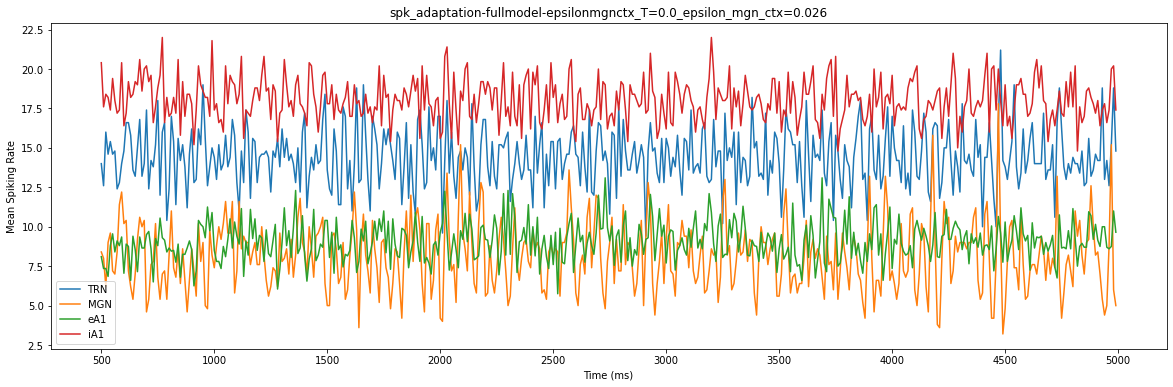

In [941]:
pth = "demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/"

f = ['spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_ctx=0.026']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 6)
#plt.ylim(-10, 70)
#plt.xlim(500, 500)

ax.plot(p.spikeobj['TRN'].time_slice(500, 5000).firing_rate(10, average=True), label='TRN')
ax.plot(p.spikeobj['MGN'].time_slice(500, 5000).firing_rate(10, average=True), label='MGN')
ax.plot(p.spikeobj['eA1'].time_slice(500, 5000).firing_rate(10, average=True), label='eA1')
ax.plot(p.spikeobj['iA1'].time_slice(500, 5000).firing_rate(10, average=True), label='iA1')

plt.title(f[0])
plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

plt.xticks(range(0, 451, 50), range(500, 5001, 500))

ax.legend()

'''print("MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 5000).mean_rate(), \
      p.spikeobj['TRN'].time_slice(500, 5000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(500, 5000).mean_rate(), \
      p.spikeobj['iA1'].time_slice(500, 5000).mean_rate(), \
     )
print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))''';

In [940]:
df[df.epsilon_mgn_ctx == 0.026]

T  epsilon_mgn_ctx brainPart  meanSpkRate  pearsonCoeff     cvIsi  \
0  0.0            0.026       MGN     7.954345      0.001464       NaN   
3  0.0            0.026       TRN    15.346248      0.003739  0.738760   
6  0.0            0.026       eA1     9.191212      0.002640  0.753995   
9  0.0            0.026       iA1    18.152855     -0.000699  0.884625   

   meanBurstSpikePercentageCerina  meanBurstSpikePercentageMIT  
0                        3.748109                    11.633442  
3                        0.035714                     8.648069  
6                        0.000000                     3.843985  
9                        0.362799                     5.779174

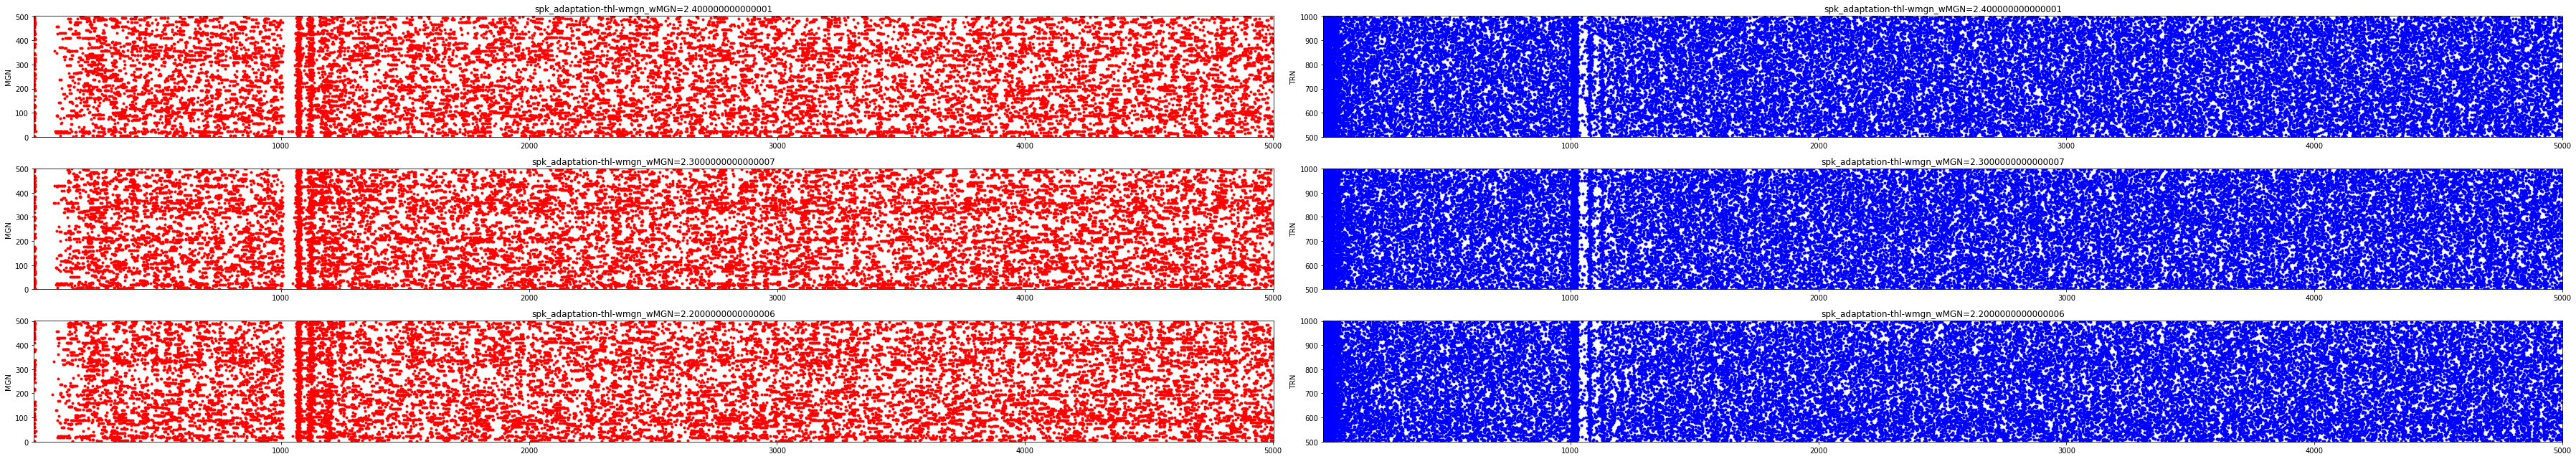

In [583]:
fls = [
    #"spk_adaptation-aone-nuxweight_T=0_nuX_aone=15_gamma_aone=3_w_input_aone=12",
    #"spk_adaptation-aone-nuxweight_T=0_nuX_aone=20_gamma_aone=9_w_input_aone=15",
    #"spk_adaptation-aone_T=0_nuX_aone=13_gamma_aone=7"
    #"spk_adaptation-thl-stim_T=0_nuX_th=18_gamma_th=18_wX_TRN=1.4000000000000004",
    #"spk_adaptation-thl-stim_T=0_nuX_th=19_gamma_th=20_wX_TRN=1.3000000000000003",
    #"spk_adaptation-thl-wmgnSigma_wMGN=1.4000000000000001_sigma_MGN=0.2_sigma_TRN=0.2",
    #"spk_adaptation-thl-wmgnSigma_wMGN=1.4000000000000001_sigma_MGN=0.2_sigma_TRN=0.2",
    'spk_adaptation-thl-wmgn_wMGN=2.400000000000001',
    'spk_adaptation-thl-wmgn_wMGN=2.3000000000000007',
    'spk_adaptation-thl-wmgn_wMGN=2.2000000000000006'
    ]
fig, ax = plt.subplots(nrows=len(fls), ncols=2)
#pth = "demyelination/data/adaptation-thl-stim/activity/"
#pth = "demyelination/data/adaptation-thl-stim/activity/"
pth = "demyelination/data/adaptation-thl-wmgn/activity/"

makerasterplot(fls, pth, fig, ax)

In [158]:
p.spikeobj['MGN'].mean_rate(), p.spikeobj['TRN'].mean_rate()

(9.132392674872412, 16.97277822257806)

In [963]:
! ls demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/

'spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_ctx=0.013'
'spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_ctx=0.026'
'spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_ctx=0.05'


MEAN SPIKING RATE:  8.159 14.338
CV_ISI:  nan 0.6845546842813491
PEARSON COEFF:  0.0014642736780992977 0.0037387766924553093


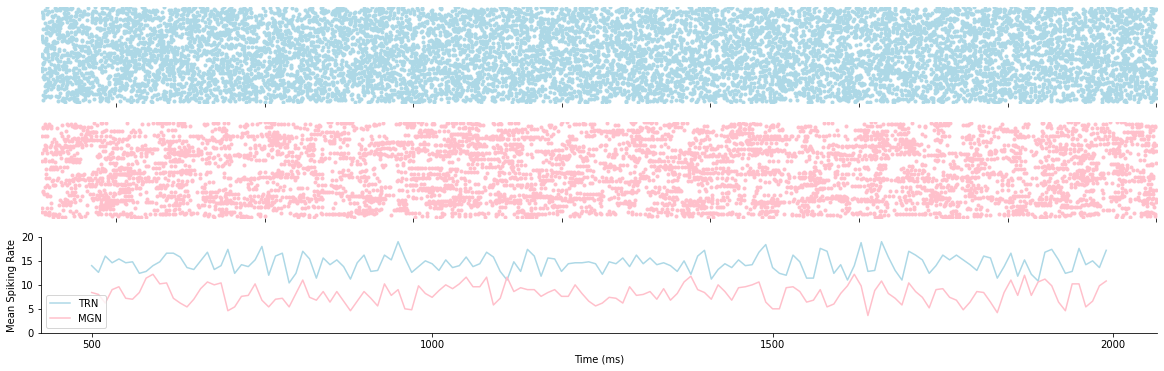

In [1012]:
pth = "demyelination/data/adaptation-fullmodel-epsilonmgnctx/activity/"
f = ['spk_adaptation-fullmodel-epsilonmgnctx_T=0.0_epsilon_mgn_ctx=0.026']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(20, 6)
#plt.title(f[0])
plt.ylim(0, 20)

for x in [0, 1]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

p.spikeobj['TRN'].time_slice(500, 2000).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(500, 2000).raster_plot(ax=ax[1], dt=10, display=False, color='pink')

ax[2].plot(p.spikeobj['TRN'].time_slice(500, 2000).firing_rate(10, average=True), label='TRN', c='lightblue')
ax[2].plot(p.spikeobj['MGN'].time_slice(500, 2000).firing_rate(10, average=True), label='MGN', c='pink')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

plt.xticks(range(0, 151, 50), range(500, 2001, 500))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[2].legend()

print("MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(2000, 4000).mean_rate(), p.spikeobj['TRN'].time_slice(2000, 4000).mean_rate())
print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

MEAN SPIKING RATE:  8.446 14.352
CV_ISI:  nan 0.6758885111510754
PEARSON COEFF:  0.006046438177926701 0.0003084407071508409


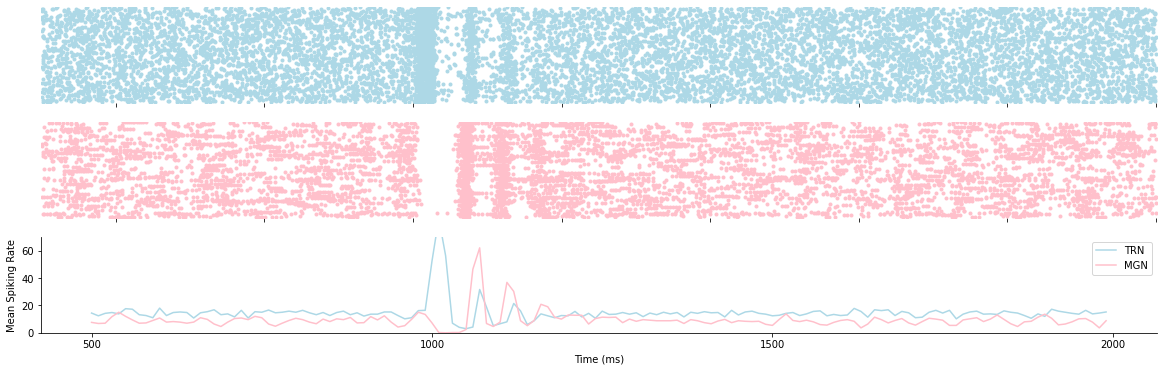

In [1014]:
pth = "demyelination/data/adaptation-thl-mgnactivity/activity/"
f = ['spk_adaptation-thl-mgnactivity_nuX_th=19.0_gamma_th=20.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(20, 6)
plt.ylim(0, 70)
#plt.title(f[0])

for x in [0, 1]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

p.spikeobj['TRN'].time_slice(500, 2000).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(500, 2000).raster_plot(ax=ax[1], dt=10, display=False, color='pink')

ax[2].plot(p.spikeobj['TRN'].time_slice(500, 2000).firing_rate(10, average=True), label='TRN', c='lightblue')
ax[2].plot(p.spikeobj['MGN'].time_slice(500, 2000).firing_rate(10, average=True), label='MGN', c='pink')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

plt.xticks(range(0, 151, 50), range(500, 2001, 500))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[2].legend()

print("MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(2000, 4000).mean_rate(), p.spikeobj['TRN'].time_slice(2000, 4000).mean_rate())
print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

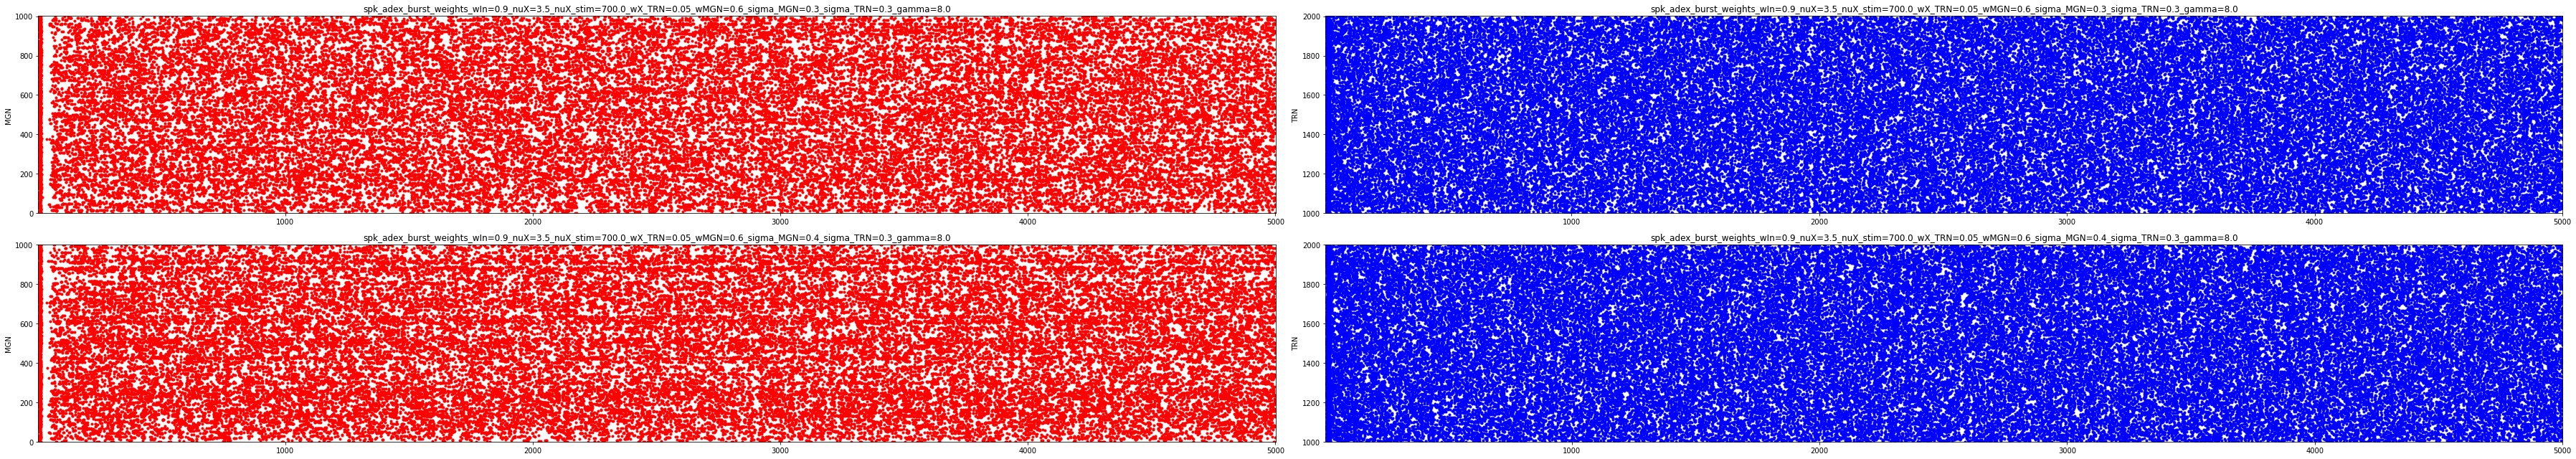

In [342]:
fls = [
    "spk_adex_burst_weights_wIn=0.9_nuX=3.5_nuX_stim=700.0_wX_TRN=0.05_wMGN=0.6_sigma_MGN=0.3_sigma_TRN=0.3_gamma=8.0",
    "spk_adex_burst_weights_wIn=0.9_nuX=3.5_nuX_stim=700.0_wX_TRN=0.05_wMGN=0.6_sigma_MGN=0.4_sigma_TRN=0.3_gamma=8.0",
    ]
fig, ax = plt.subplots(nrows=len(fls), ncols=2)
pth = "demyelination/data/adex_burst_weights_wIn=0.9/activity/"

makerasterplot(fls, pth, fig, ax)

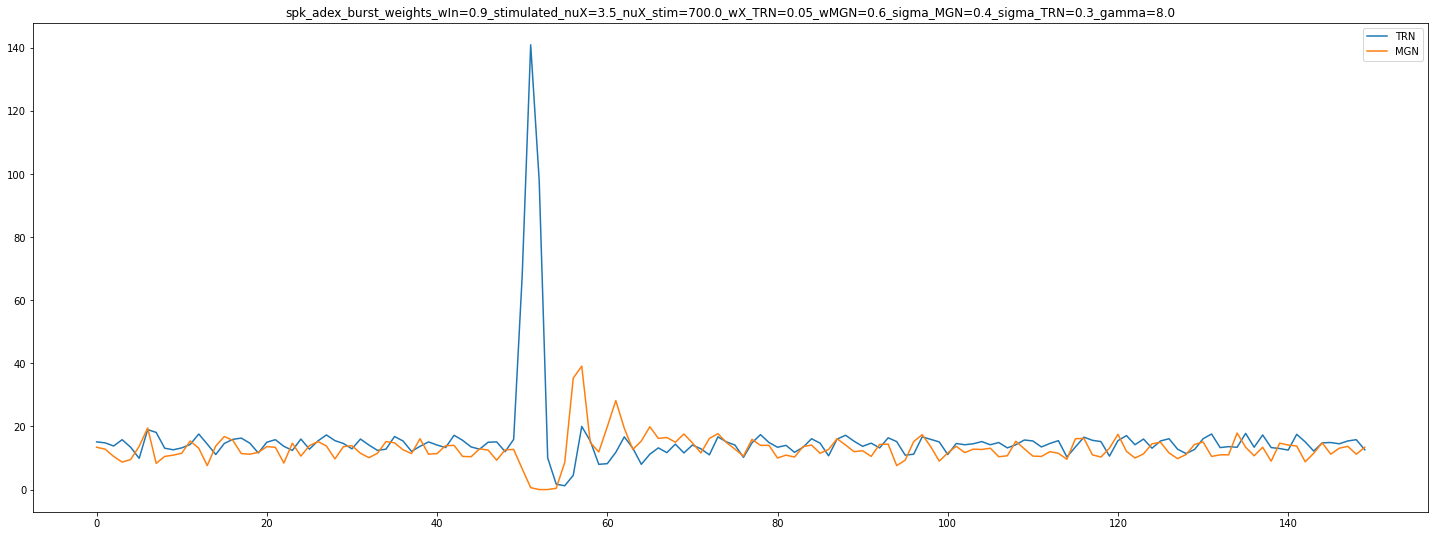

In [352]:
fl = 'spk_adex_burst_weights_wIn=0.9_stimulated_nuX=3.5_nuX_stim=700.0_wX_TRN=0.05_wMGN=0.6_sigma_MGN=0.4_sigma_TRN=0.3_gamma=8.0'
p = pd.read_pickle("demyelination/data/adex_burst_weights_wIn=0.9_stimulated/activity/" + fl)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(25, 9)

ax.plot(p.spikeobj['TRN'].time_slice(500, 2000).firing_rate(10, average=True), label='TRN')
ax.plot(p.spikeobj['MGN'].time_slice(500, 2000).firing_rate(10, average=True), label='MGN')

plt.title(fl)

ax.legend()


## With Stim

In [340]:
files2 = pipeline.readfiles("demyelination/data/adex_burst_weights_wIn=0.9_stimulated/activity/");
df2 = preparedf(files2);

In [284]:
fig, ax = plt.subplots(nrows=4, ncols=2)

fig.set_size_inches(13, 9)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

x = 0.4

makesubplot(df3[df3.sigma_MGN == x], fig, ax[0], "cvIsi")

makesubplot(df3[df3.sigma_MGN == x], fig, ax[1], "meanSpkRate")

makesubplot(df3[df3.sigma_MGN == x], fig, ax[2], "pearsonCoeff")

makesubplot(df3[df3.sigma_MGN == x], fig, ax[3], "meanBurstSpikeCount")

fig.tight_layout()

plt.show()

## MGN Burst Probability

In [1145]:
burstfiles = pipeline.readfiles("demyelination/data/adaptation-thl-burstprob/activity/");

pre, post = [], []

for fl in burstfiles:
    pre.append(np.mean(computePopulationBurstSpikeRatio( fl.spikeobj['MGN'].time_slice(500, 2500), "mit" )))
    post.append(np.mean(computePopulationBurstSpikeRatio( fl.spikeobj['MGN'].time_slice(2500, 4500), "mit" )))


[PIPELINE readfiles] fetching data from folder  demyelination/data/adaptation-thl-burstprob/activity/
[PIPELINE readfiles] fetched filenames
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=68.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=53.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=19.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=75.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_ada

[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=85.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=23.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=13.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=89.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-burstprob/activity/spk_adaptation-thl-burstprob_T=40.0
[PIPELINE readfiles] read file 
[PIPELINE rea

In [1146]:
x = 0
for pr, po in zip(pre, post):
    if po > pr: x+=1
print(x)

58


100 100


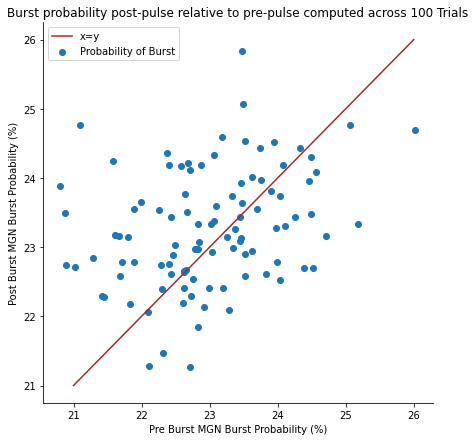

In [1036]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(7, 7)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

x = np.arange(21, 27, 1)
ax.plot(x, x, c='brown', label='x=y')

ax.scatter(pre, post, label="Probability of Burst")

plt.title("Burst probability post-pulse relative to pre-pulse computed across 100 Trials")
plt.xlabel("Pre Burst MGN Burst Probability (%)")
plt.ylabel("Post Burst MGN Burst Probability (%)")
plt.legend()


## MGN Burst Probability Full Model

In [1160]:
burstfiles = pipeline.readfiles("demyelination/data/adaptation-fullmodel-burstexp/activity/");

pre, post = [], []

for fl in burstfiles:
    pre.append(np.mean(computePopulationBurstSpikeRatio( fl.spikeobj['MGN'].time_slice(500, 2500), "mit" )))
    post.append(np.mean(computePopulationBurstSpikeRatio( fl.spikeobj['MGN'].time_slice(2500, 4500), "mit" )))


[PIPELINE readfiles] fetching data from folder  demyelination/data/adaptation-fullmodel-burstexp/activity/
[PIPELINE readfiles] fetched filenames
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=85.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=45.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=74.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=61.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read fil

[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=32.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=44.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=1.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=58.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyeli

[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-fullmodel-burstexp/activity/spk_adaptation-fullmodel-burstexp_T=25.0_epsilon_mgn_ctx=0.026
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 


In [1162]:
np.mean(post)

22.558919148798335

In [1149]:
x = 0
for pr, po in zip(pre, post):
    if po > pr: x+=1
print(x)

14


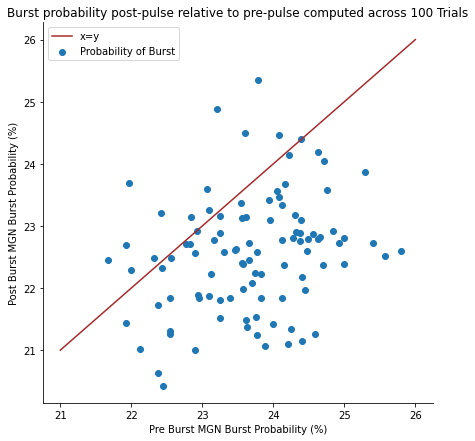

In [1150]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(7, 7)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

x = np.arange(21, 27, 1)
ax.plot(x, x, c='brown', label='x=y')

ax.scatter(pre, post, label="Probability of Burst")

plt.title("Burst probability post-pulse relative to pre-pulse computed across 100 Trials")
plt.xlabel("Pre Burst MGN Burst Probability (%)")
plt.ylabel("Post Burst MGN Burst Probability (%)")
plt.legend()


## Thalamus Spike Histogram

In [1141]:
histfiles = pipeline.readfiles("demyelination/data/adaptation-thl-nobursthist/activity/");

[PIPELINE readfiles] fetching data from folder  demyelination/data/adaptation-thl-nobursthist/activity/
[PIPELINE readfiles] fetched filenames
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=58.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=97.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=86.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=37.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursth

[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=71.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=74.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=55.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=42.0
[PIPELINE readfiles] read file 
[PIPELINE readfiles] reading file 
[PIPELINE readfiles] reading file  demyelination/data/adaptation-thl-nobursthist/activity/spk_adaptation-thl-nobursthist_T=77.0
[PIPELINE readfiles] read

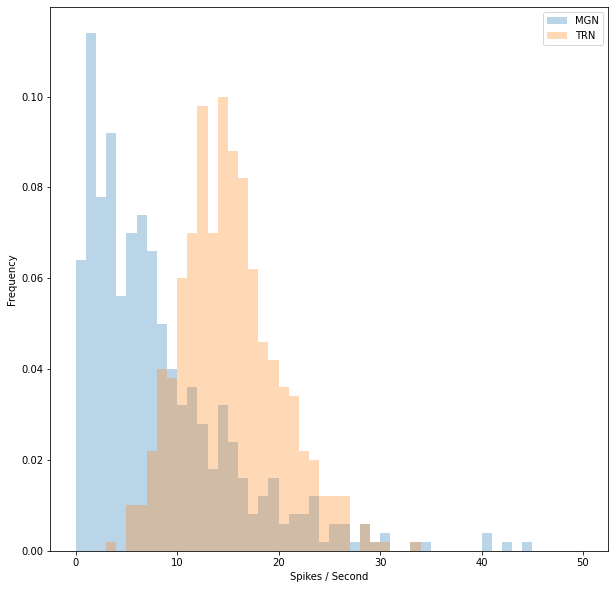

In [1144]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)

m = histfiles[5].spikeobj['MGN'].mean_rates()
t = histfiles[5].spikeobj['TRN'].mean_rates()

ax.hist(m, alpha=0.3, label="MGN", bins=50, range=(0, 50), density=True)
ax.hist(t, alpha=0.3, label="TRN", bins=50, range=(0, 50), density=True)

plt.ylabel("Frequency")
plt.xlabel("Spikes / Second")

#plt.xlim(0, 40)

plt.legend();

# for no stim, post prob is 58, which is the same as when there is stimulation

In [638]:
# for nuX_aone in [15, 20, 25]:
#     for scale_eps in [1, 2, 4]:
#         for scale_w in [1, 2, 3, 4]:
#             for wX_TRN in np.arange(1.1, 1.5, .1):
#                 for nuX_th in np.arange(15., 21. 1.):
#                     qdf = nonhomo_df[nonhomo_df.nuX_aone = nuX_aone]\
#                     [nonhomo_df.scale_eps == scale_eps][nonhomo_df.scale_w == scale_w]\
#                     [nonhomo_df.wX_TRN == wX_TRN][nonhomo_df.nuX_th == nuX_th]
                    
#                     if qdf[qdf.brainPart == 'MGN']['meanSpkRate'] < 7: continue
#                     if qdf[qdf.brainPart == 'MGN']['meanSpkRate'] > 11: continue

SyntaxError: invalid syntax (<ipython-input-638-028ef25cfd41>, line 5)

## [Non Homogenous] High EPSP with varying weights

In [ ]:
files2 = pipeline.readfiles("demyelination/data/nonhomg-eps-wgh/activity/");

In [546]:
nonhomo_df = preparedf(files2);

In [641]:
pivot_df = pd.pivot_table(nonhomo_df, values='meanSpkRate', columns='brainPart', index=['nuX_th', 'wX_TRN', 'scale_w', 'scale_eps', 'nuX_aone'])

In [643]:
pivot_df

brainPart                                       MGN        TRN       eA1  \
nuX_th wX_TRN scale_w scale_eps nuX_aone                                   
15.0   1.1    1.0     1.0       15.0      15.582783   9.820649  5.238262   
                                20.0      15.100587  10.129122  6.980148   
                                25.0      15.550350  10.169946  8.838073   
                      2.0       15.0      15.600313   9.923735  5.339310   
                                20.0      15.410519  10.067456  7.234652   
...                                             ...        ...       ...   
20.0   1.4    4.0     2.0       20.0       6.090003  19.047314  7.490245   
                                25.0       6.295495  19.187800  9.194581   
                      4.0       15.0       5.652574  19.419571  6.031281   
                                20.0       5.718175  19.911136  7.889561   
                                25.0       6.064488  19.573728  9.746138   

brainPart                                       iA1  
nuX_th wX_TRN scale_w scale_eps nuX_aone             
15.0   1.1    1.0     1.0       15.0       7.904808  
                                20.0      10.833450  
                                25.0      13.879528  
                      2.0       15.0       8.151543  
                                20.0      11.071929  
...                                             ...  
20.0   1.4    4.0     2.0       20.0      11.342220  
                                25.0      14.411670  
                      4.0       15.0       9.160345  
                                20.0      12.046669  
                                25.0      15.388991  

[864 rows x 4 columns]

In [652]:
pivot_df[\
        ((pivot_df.MGN >= 7) & (pivot_df.MGN <= 11)) & \
        ((pivot_df.TRN >= 13) & (pivot_df.TRN <= 18)) & \
        ((pivot_df.eA1 >= 7) & (pivot_df.eA1 <= 11)) \
        #((pivot_df.iA1 >= 15)) \
        ].shape

(254, 4)

In [519]:
df[df.wX_TRN == 1.3000000000000003][df.nuX_aone == 15.][df.scale_eps == 4.][df.scale_w == 1.][df.brainPart == 'TRN'].sort_values("nuX_th")

nuX_th  wX_TRN  scale_w  scale_eps  nuX_aone brainPart  meanSpkRate  \
1122    15.0     1.3      1.0        4.0      15.0       TRN    12.790297   
1511    16.0     1.3      1.0        4.0      15.0       TRN    13.575089   
912     17.0     1.3      1.0        4.0      15.0       TRN    14.036070   
1538    18.0     1.3      1.0        4.0      15.0       TRN    15.405249   
1339    19.0     1.3      1.0        4.0      15.0       TRN    16.251702   
1313    20.0     1.3      1.0        4.0      15.0       TRN    16.755340   

      pearsonCoeff     cvIsi  meanBurstSpikePercentageCerina  \
1122      0.004045  0.721430                        0.147412   
1511      0.005876  0.727773                        0.085965   
912       0.000715  0.727655                        0.097222   
1538      0.001862  0.751965                        0.334157   
1339      0.001209  0.755485                        0.036364   
1313     -0.002032  0.760414                        0.106443   

      meanBurstSpikePercentageMIT  
1122                     8.551904  
1511                     9.794447  
912                      9.365214  
1538                     9.973285  
1339                    10.204714  
1313                    10.691230

In [518]:
df[df.wX_TRN == 1.3000000000000003][df.nuX_aone == 15.][df.scale_eps == 4.][df.scale_w == 1.][df.brainPart == 'MGN'].sort_values("nuX_th")

nuX_th  wX_TRN  scale_w  scale_eps  nuX_aone brainPart  meanSpkRate  \
258    15.0     1.3      1.0        4.0      15.0       MGN    10.175966   
647    16.0     1.3      1.0        4.0      15.0       MGN     9.854829   
48     17.0     1.3      1.0        4.0      15.0       MGN     9.667087   
674    18.0     1.3      1.0        4.0      15.0       MGN     8.242126   
475    19.0     1.3      1.0        4.0      15.0       MGN     8.028747   
449    20.0     1.3      1.0        4.0      15.0       MGN     7.809829   

     pearsonCoeff  cvIsi  meanBurstSpikePercentageCerina  \
258      0.001516    NaN                        7.313253   
647      0.006266    NaN                        5.498385   
48       0.006213    NaN                        4.289466   
674      0.000223    NaN                        4.967540   
475      0.002186    NaN                        4.412747   
449      0.002981    NaN                        4.175666   

     meanBurstSpikePercentageMIT  
258                    32.560558  
647                    32.392598  
48                     32.082603  
674                    27.004503  
475                    26.129642  
449                    27.183284

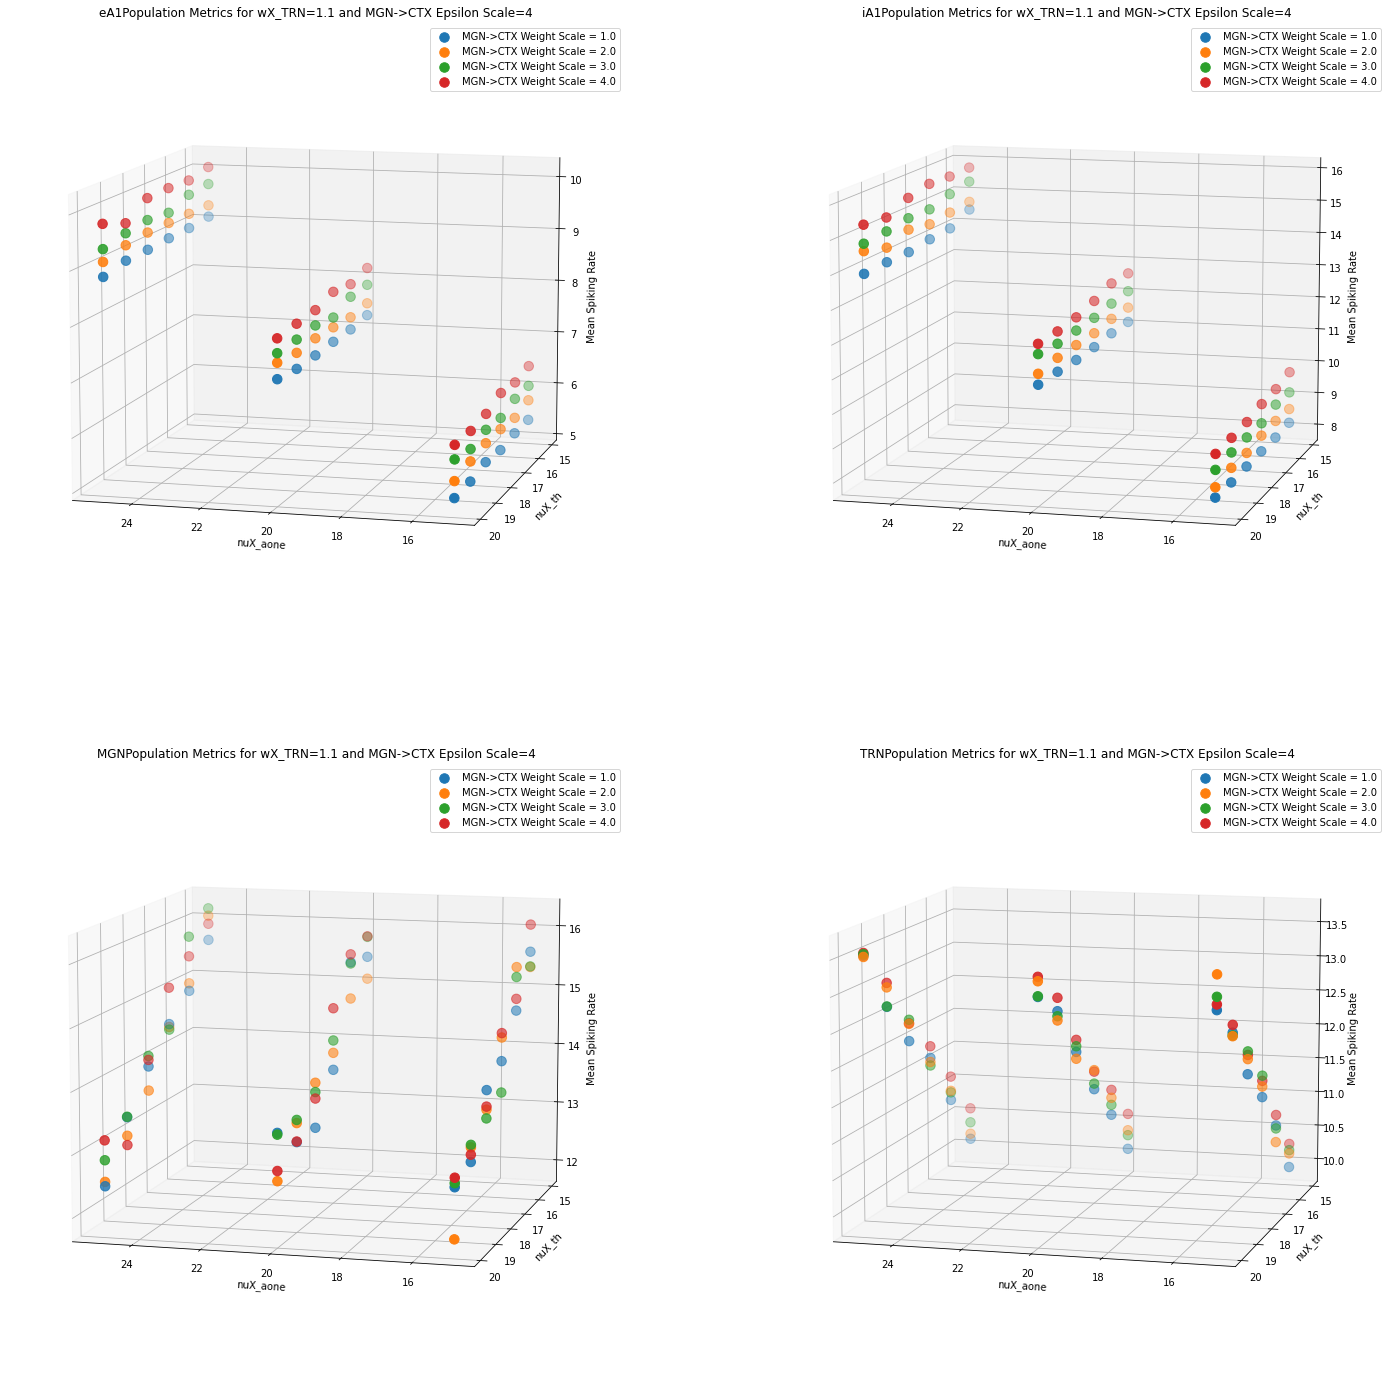

In [552]:
def gen_subplot(ax, df, brainPart):
    df_brainpart = df[df.brainPart == brainPart]
    # Data for a three-dimensional line
    for i, dff in df_brainpart.groupby("scale_w"):
        ax.scatter3D(dff.nuX_aone, dff.nuX_th, dff.meanSpkRate, \
                     'grey', label="MGN->CTX Weight Scale = " + str(i), s=90)

    ax.set_xlabel("nuX_aone")
    ax.set_ylabel("nuX_th")
    ax.set_zlabel("Mean Spiking Rate")
    
    ax.view_init(10, 465)
    
    ax.legend()
    
    ax.set_title(brainPart + "Population Metrics for wX_TRN=1.1 and MGN->CTX Epsilon Scale=4")


dfFilter = (nonhomo_df.wX_TRN == 1.1) & (nonhomo_df.scale_eps == 2.)

fig = plt.figure()
fig.set_size_inches(25, 25)

# eA1
ax = fig.add_subplot(221, projection='3d')

gen_subplot(ax, nonhomo_df[dfFilter], 'eA1')

# iA1
ax = fig.add_subplot(222, projection='3d')

gen_subplot(ax, nonhomo_df[dfFilter], 'iA1')

# MGN
ax = fig.add_subplot(223, projection='3d')

gen_subplot(ax, nonhomo_df[dfFilter], 'MGN')

# TRN
ax = fig.add_subplot(224, projection='3d')

gen_subplot(ax, nonhomo_df[dfFilter], 'TRN')


plt.legend()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/nuxaone.pdf")

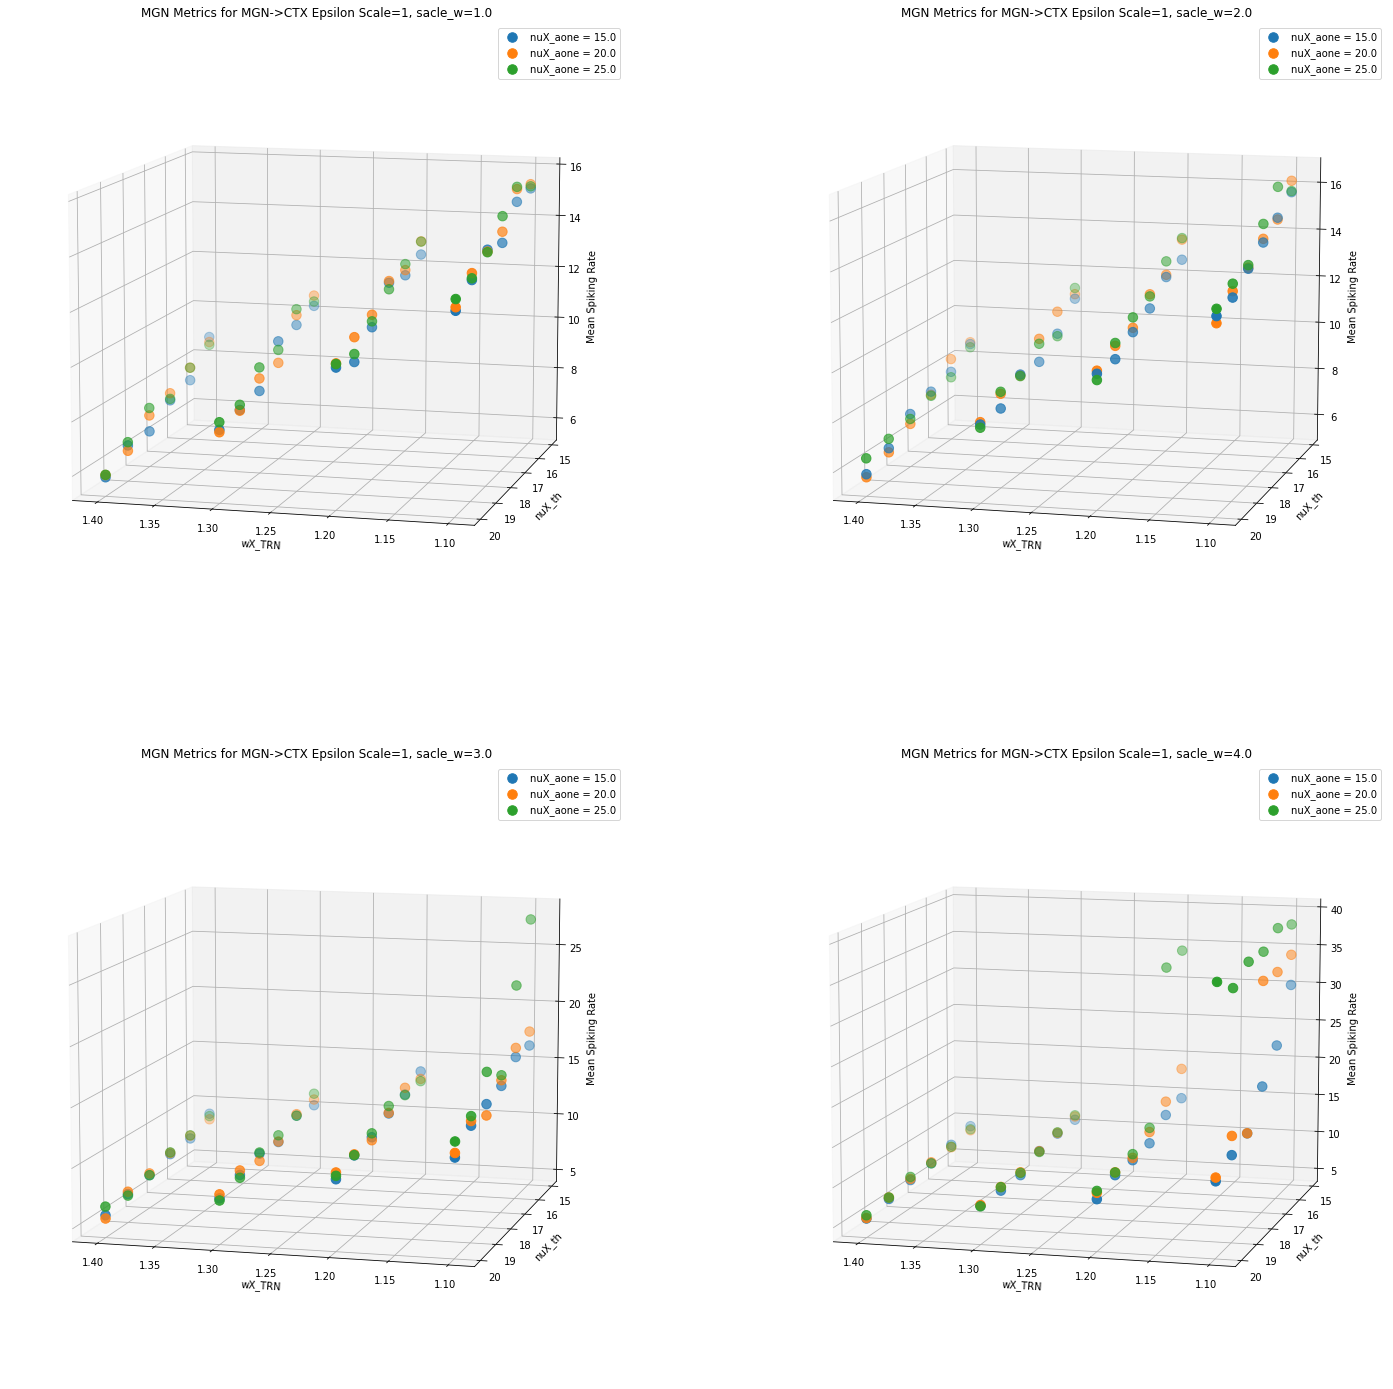

In [494]:
def gen_subplot(ax, df, brainPart):
    df_brainpart = df[df.scale_w == brainPart]

    for i, dff in df_brainpart.groupby("nuX_aone"):
        ax.scatter3D(dff.wX_TRN, dff.nuX_th, dff.meanSpkRate, \
                     'grey', label="nuX_aone = " + str(i), s=90)

    ax.set_xlabel("wX_TRN")
    ax.set_ylabel("nuX_th")
    ax.set_zlabel("Mean Spiking Rate")
    
    ax.view_init(10, 465)
    
    ax.legend()
    
    ax.set_title("MGN Metrics for MGN->CTX Epsilon Scale=1, sacle_w=" + str(brainPart))


dfFilter = (df.brainPart == 'MGN') & (df.scale_eps == 4.)

fig = plt.figure()
fig.set_size_inches(25, 25)

# eA1
ax = fig.add_subplot(221, projection='3d')

gen_subplot(ax, df[dfFilter], 1.)

# iA1
ax = fig.add_subplot(222, projection='3d')

gen_subplot(ax, df[dfFilter], 2.)

# MGN
ax = fig.add_subplot(223, projection='3d')

gen_subplot(ax, df[dfFilter], 3.)

# TRN
ax = fig.add_subplot(224, projection='3d')

gen_subplot(ax, df[dfFilter], 4.)


plt.legend()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/nuxaone.pdf")

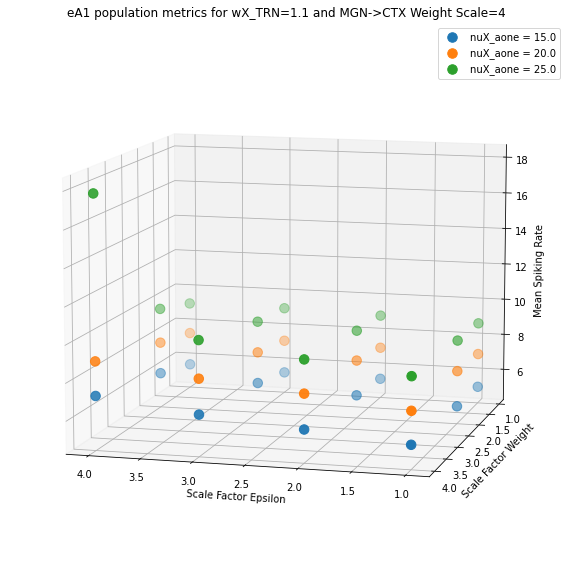

In [408]:
dfFilter = (df.wX_TRN == 1.1) & (df.nuX_th == 20.) & (df.brainPart == 'eA1')

fig = plt.figure()
ax = plt.axes(projection='3d')
fig.set_size_inches(10, 15)

ax.view_init(10, 465)

# Data for a three-dimensional line
for i, dff in df[dfFilter].groupby("nuX_aone"):
    ax.scatter3D(dff.scale_w, dff.scale_eps, dff.meanSpkRate, \
                 'grey', label="nuX_aone = " + str(i), s=90)


ax.set_xlabel("Scale Factor Epsilon")
ax.set_ylabel("Scale Factor Weight")
ax.set_zlabel("Mean Spiking Rate")

plt.legend()

plt.title("eA1 population metrics for wX_TRN=1.1 and MGN->CTX Weight Scale=4")

plt.show()


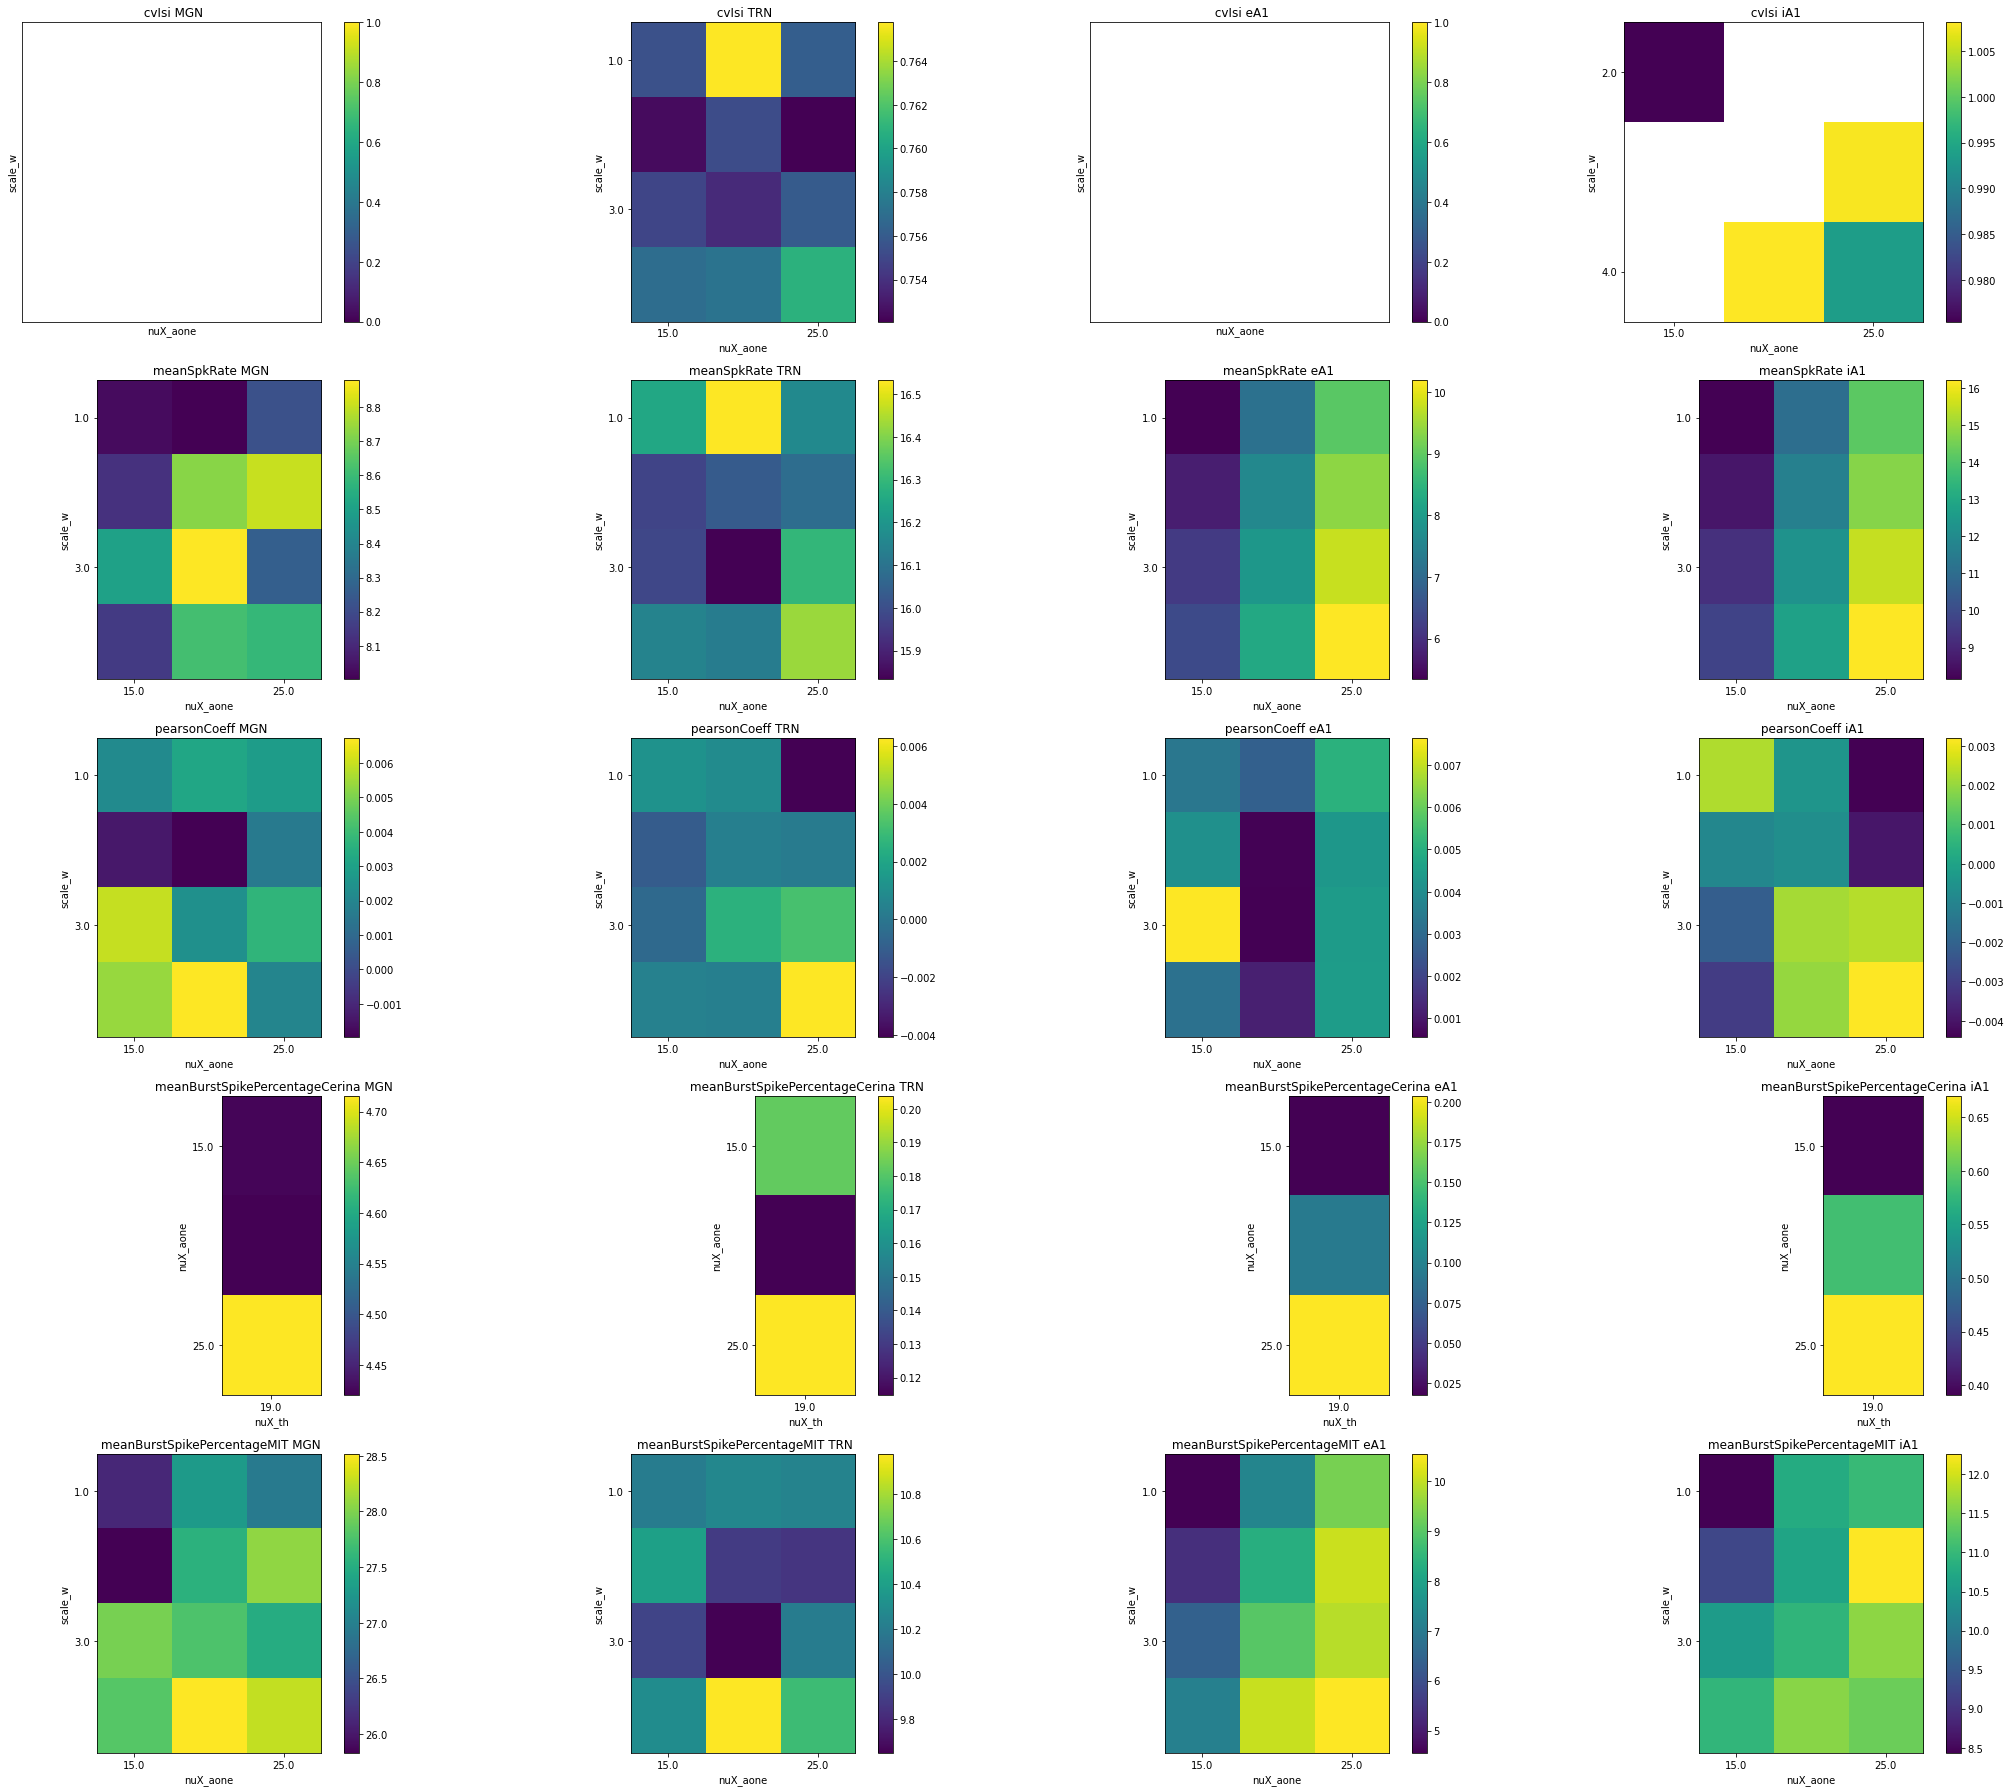

In [217]:
fig, ax = plt.subplots(nrows=5, ncols=4)

fig.set_size_inches(30, 25)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

# dfFilter = df.wX_TRN < 1.6
# dfFilter = [True] * df.shape[0]

makesubplot(df[dfFilter], fig, ax[0], "cvIsi", "scale_w", "nuX_aone", ["MGN", "TRN", "eA1", "iA1"])

makesubplot(df[dfFilter], fig, ax[1], "meanSpkRate", "scale_w", "nuX_aone", ["MGN", "TRN", "eA1", "iA1"])

makesubplot(df[dfFilter], fig, ax[2], "pearsonCoeff", "scale_w", "nuX_aone", ["MGN", "TRN", "eA1", "iA1"])

makesubplot(df[dfFilter], fig, ax[3], "meanBurstSpikePercentageCerina", "nuX_aone", "nuX_th", ["MGN", "TRN", "eA1", "iA1"])

makesubplot(df[dfFilter], fig, ax[4], "meanBurstSpikePercentageMIT", "scale_w", "nuX_aone", ["MGN", "TRN", "eA1", "iA1"])

fig.tight_layout()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/adaptation-aone_winputaone=15.pdf")

In [683]:
nonhomo_df[nonhomo_df.wX_TRN == 1.3000000000000003][nonhomo_df.scale_eps == 2.][nonhomo_df.scale_w == 4.]\
[nonhomo_df.nuX_th == 20.][nonhomo_df.nuX_aone == 25.]
#[nonhomo_df.brainPart == 'MGN']['meanSpkRate']

nuX_th  wX_TRN  scale_w  scale_eps  nuX_aone brainPart  meanSpkRate  \
60      20.0     1.3      4.0        2.0      25.0       MGN     8.033148   
924     20.0     1.3      4.0        2.0      25.0       TRN    16.995317   
1788    20.0     1.3      4.0        2.0      25.0       eA1     9.339783   
2652    20.0     1.3      4.0        2.0      25.0       iA1    14.629901   

      pearsonCoeff     cvIsi  meanBurstSpikePercentageCerina  \
60        0.000585       NaN                        4.025331   
924       0.004192  0.765400                        0.318549   
1788      0.001425       NaN                        0.344223   
2652     -0.000798  1.007034                        1.046079   

      meanBurstSpikePercentageMIT  
60                      26.360590  
924                      9.900331  
1788                    10.190988  
2652                    11.507247

MEAN SPIKING RATE:  5.87 18.247
CV_ISI:  nan 0.7455227089524269
PEARSON COEFF:  0.001222150468119791 0.005822342925303754


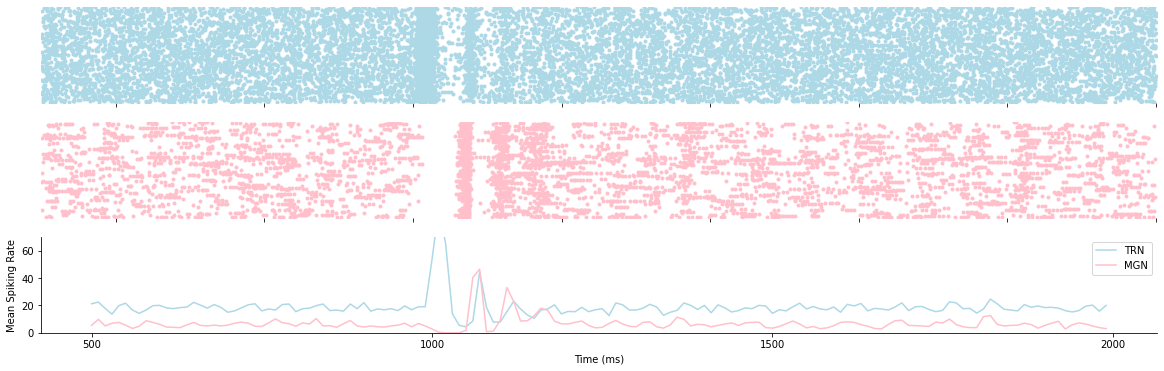

In [1226]:
'''
spk_nonhomg-eps-wgh_nuX_th=15.0_wX_TRN=1.4000000000000004_scale_w=4.0_scale_eps=1.0_nuX_aone=15.0
Leads to good oscillatory behaviour
'''
pth = "demyelination/data/nonhomg-eps-wgh/activity/"
f = ['spk_nonhomg-eps-wgh_nuX_th=20.0_wX_TRN=1.4000000000000004_scale_w=4.0_scale_eps=4.0_nuX_aone=25.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(20, 6)
plt.ylim(0, 70)
#plt.title(f[0])

for x in [0, 1]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

p.spikeobj['TRN'].time_slice(500, 2000).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(500, 2000).raster_plot(ax=ax[1], dt=10, display=False, color='pink')

ax[2].plot(p.spikeobj['TRN'].time_slice(500, 2000).firing_rate(10, average=True), label='TRN', c='lightblue')
ax[2].plot(p.spikeobj['MGN'].time_slice(500, 2000).firing_rate(10, average=True), label='MGN', c='pink')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

plt.xticks(range(0, 151, 50), range(500, 2001, 500))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[2].legend()

print("MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(2000, 4000).mean_rate(), p.spikeobj['TRN'].time_slice(2000, 4000).mean_rate())
print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

## MGN Stim

In [1650]:
def preparedf (dataobjs):
    
    parts = dataobjs[0].spikeobj.keys()

    df = pd.DataFrame()

    for part in parts:
        for data in dataobjs:
            #data.spikeobj[part].time_offset(250)
            tmp = data.params
            tmp = tmp.update({
                "brainPart" : part,
                "meanSpkRate" : data.spikeobj[part].time_slice(1000, 2000).mean_rate(),
                "pearsonCoeff" : data.spikeobj[part].time_slice(1000, 2000).pairwise_pearson_corrcoeff(nb_pairs=2000, time_bin=10)[0],
                "cvIsi" : data.spikeobj[part].time_slice(1000, 2000).cv_isi().mean(),
                #"meanBurstSpikePercentageCerina" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part].time_slice(3000, 5000), "cerina" )),
                #"meanBurstSpikePercentageMIT" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part].time_slice(3000, 5000), "mit" )),
                #"meanBurstSpikePercentage" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part] ))
            })
            df = df.append(data.params, ignore_index=True)

    return df

MEAN SPIKING RATE:  8.49 19.32 8.142
MEAN SPIKING RATE:  12.3225 19.565 12.2205
PEARSON COEFF:  0.013973877950189575 0.026684351395616434 -0.0019235494300855708
PEARSON COEFF:  0.02644395415355443 0.030751240568286625 -0.0006394880177325667


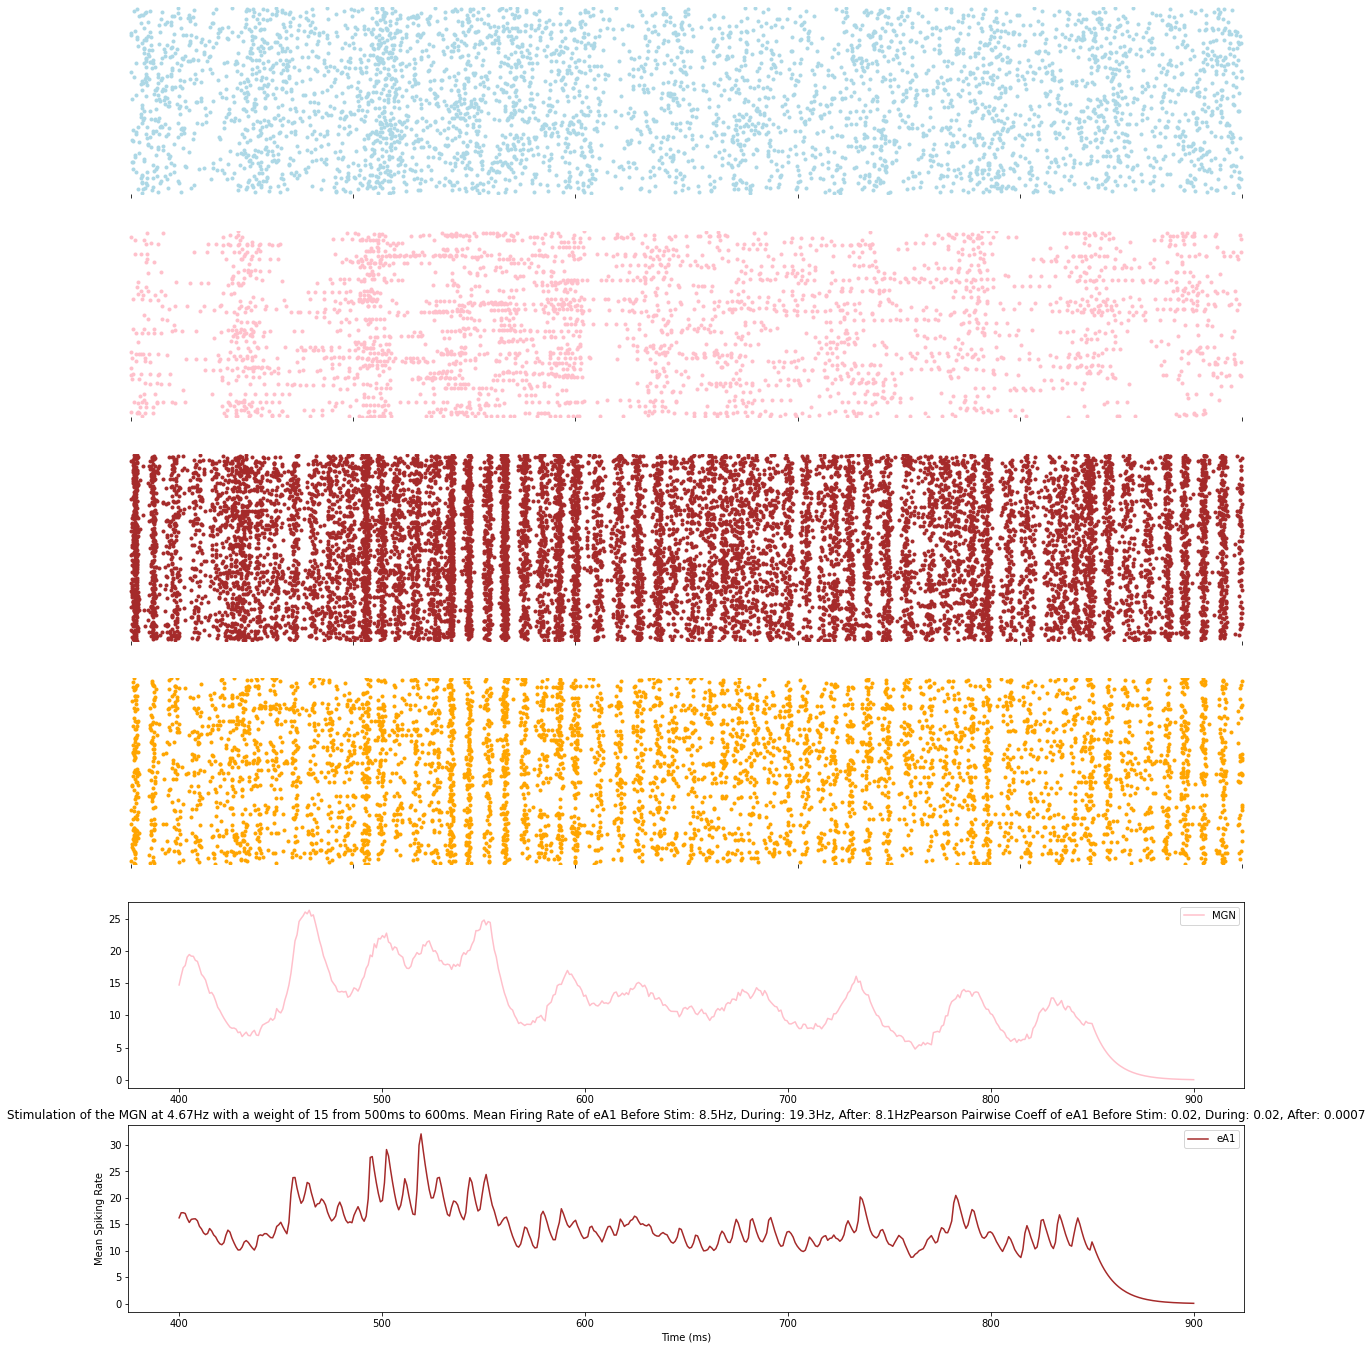

In [1286]:
pth = "demyelination/data/mgn20hz-highweight/activity/"
#f = ['spk_mgnstim-200s_nuX_stim=10.0_w_th_stimscale=31.0']
f = ['spk_mgn20hz-highweight_w_th_stimscale=16.0_scale_w=15.0_stim_dur=100.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 400
tstop = 900
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='TRN', c='lightblue')

x, y = smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')

x, y = smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(300, 500).mean_rate(), \
      p.spikeobj['MGN'].time_slice(500, 600).mean_rate(),\
      p.spikeobj['MGN'].time_slice(1000, 2000).mean_rate())
print("MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(300, 500).mean_rate(), \
      p.spikeobj['eA1'].time_slice(500, 600).mean_rate(),\
      p.spikeobj['eA1'].time_slice(1000, 2000).mean_rate())
print("PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(300, 500).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(500, 600).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(1000, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(300, 500).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(500, 600).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(1000, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

MEAN SPIKING RATE:  4.381333333333334 10.46 4.419
MEAN SPIKING RATE:  10.605666666666666 15.675 10.678
PEARSON COEFF:  0.002917019147322659 -0.02474011759634704 0.0009943875462041394
PEARSON COEFF:  0.006499084948260469 0.022963949958267293 0.0005202715692974458


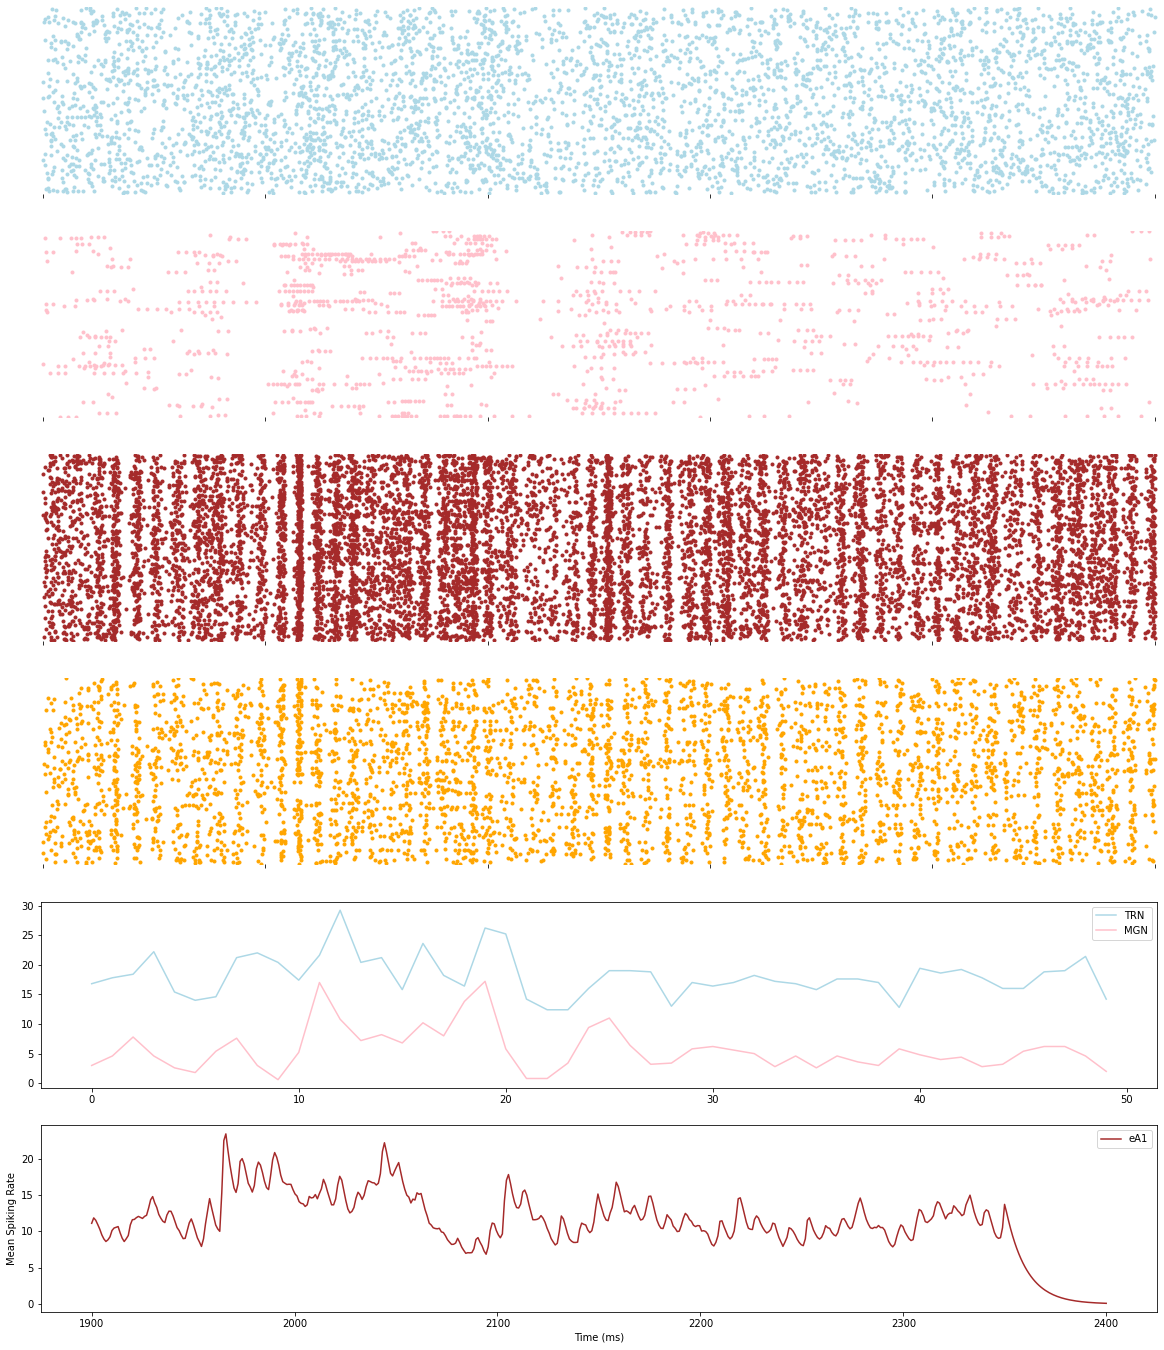

In [1371]:
pth = "demyelination/data/weakcoupling/activity/"
f = ['spk_weakcoupling_scale_w=15.0_gamma_th=40.0_wX_TRN=1.4']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1900
tstop = 2400
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

# x, y = smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
# ax[4].plot(x, y, label='TRN', c='lightblue')
ax[4].plot(p.spikeobj['TRN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='TRN', c='lightblue')

# x, y = smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
# ax[4].plot(x, y, label='MGN', c='pink')
ax[4].plot(p.spikeobj['MGN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='MGN', c='pink')

x, y = smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

MGN MEAN SPIKING RATE:  8.046666666666667 18.72 7.96
eA1 MEAN SPIKING RATE:  11.773333333333333 16.885 12.08625
eA1 PEARSON COEFF:  0.00529899838360131 0.0022667252624919048 0.01097393562785325
MGN PEARSON COEFF:  0.0037972452983437393 0.03684973143054807 0.0065965319973018775


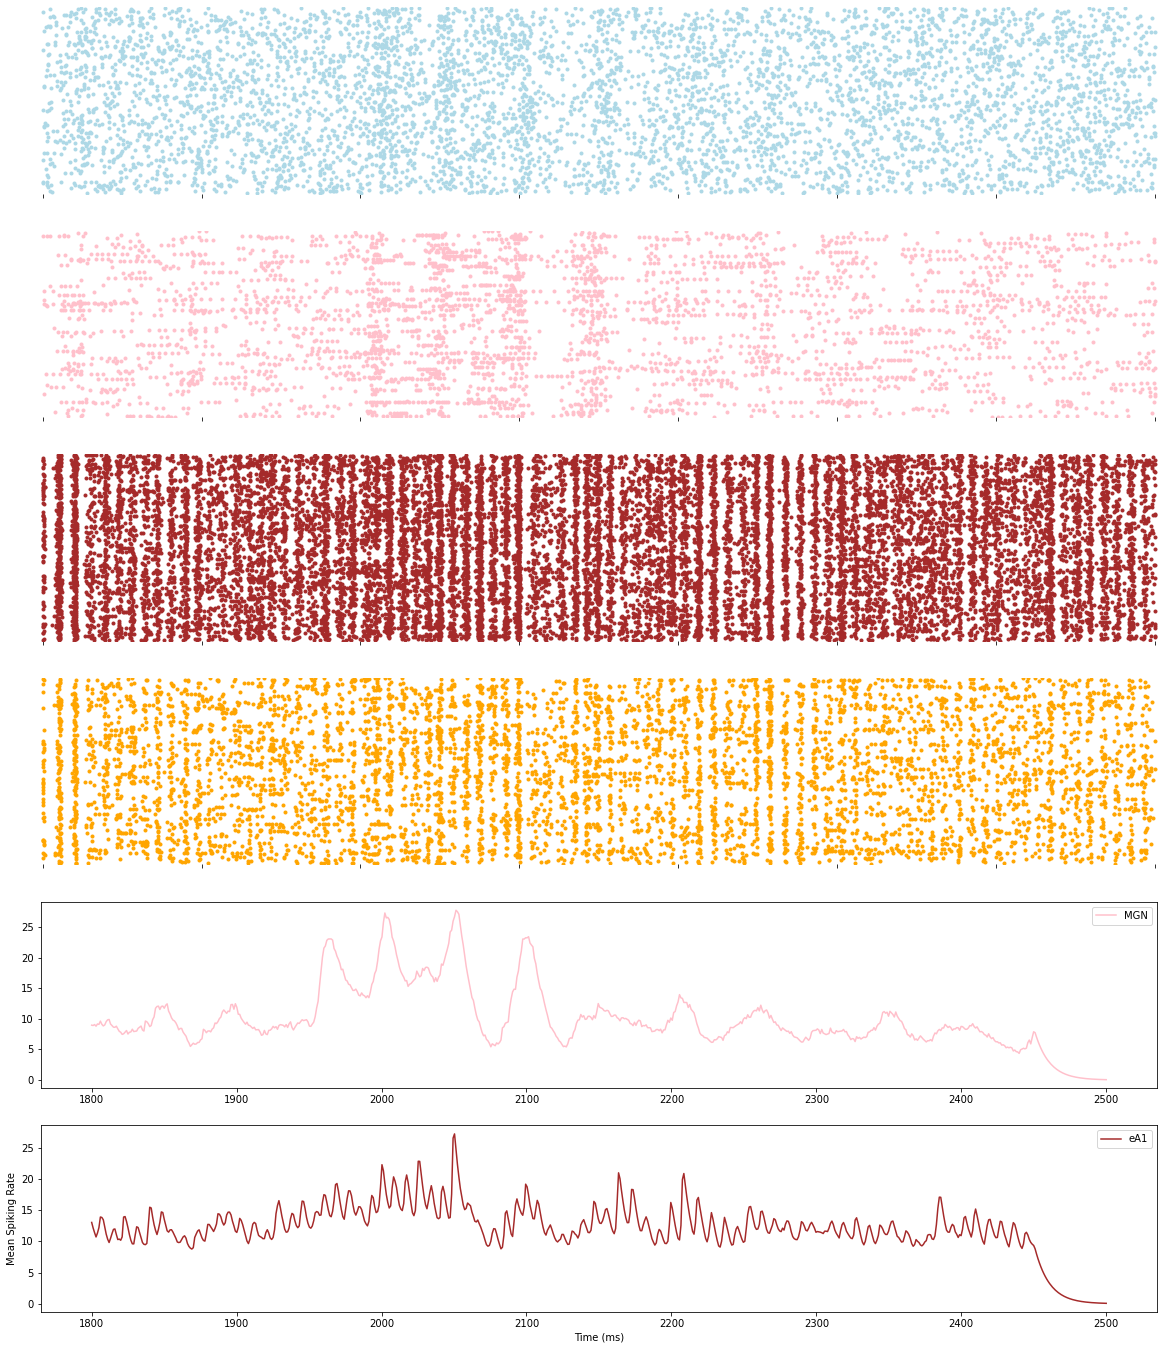

In [1278]:
pth = "demyelination/data/weakaone/activity/"
f = ['spk_weakaone_nuX_aone=30.0_gamma_aone=15.0_w_aone=3.0_stim_dur=100.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1800
tstop = 2500
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='TRN', c='lightblue')

x, y = smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')

x, y = smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

MGN MEAN SPIKING RATE:  4.38 9.68 4.604
eA1 MEAN SPIKING RATE:  13.273 18.345 13.5315
eA1 PEARSON COEFF:  0.007831097151485314 0.019946735941782485 0.01082419267524876
MGN PEARSON COEFF:  0.012285589721227971 0.006631387010835193 0.006687485940347586


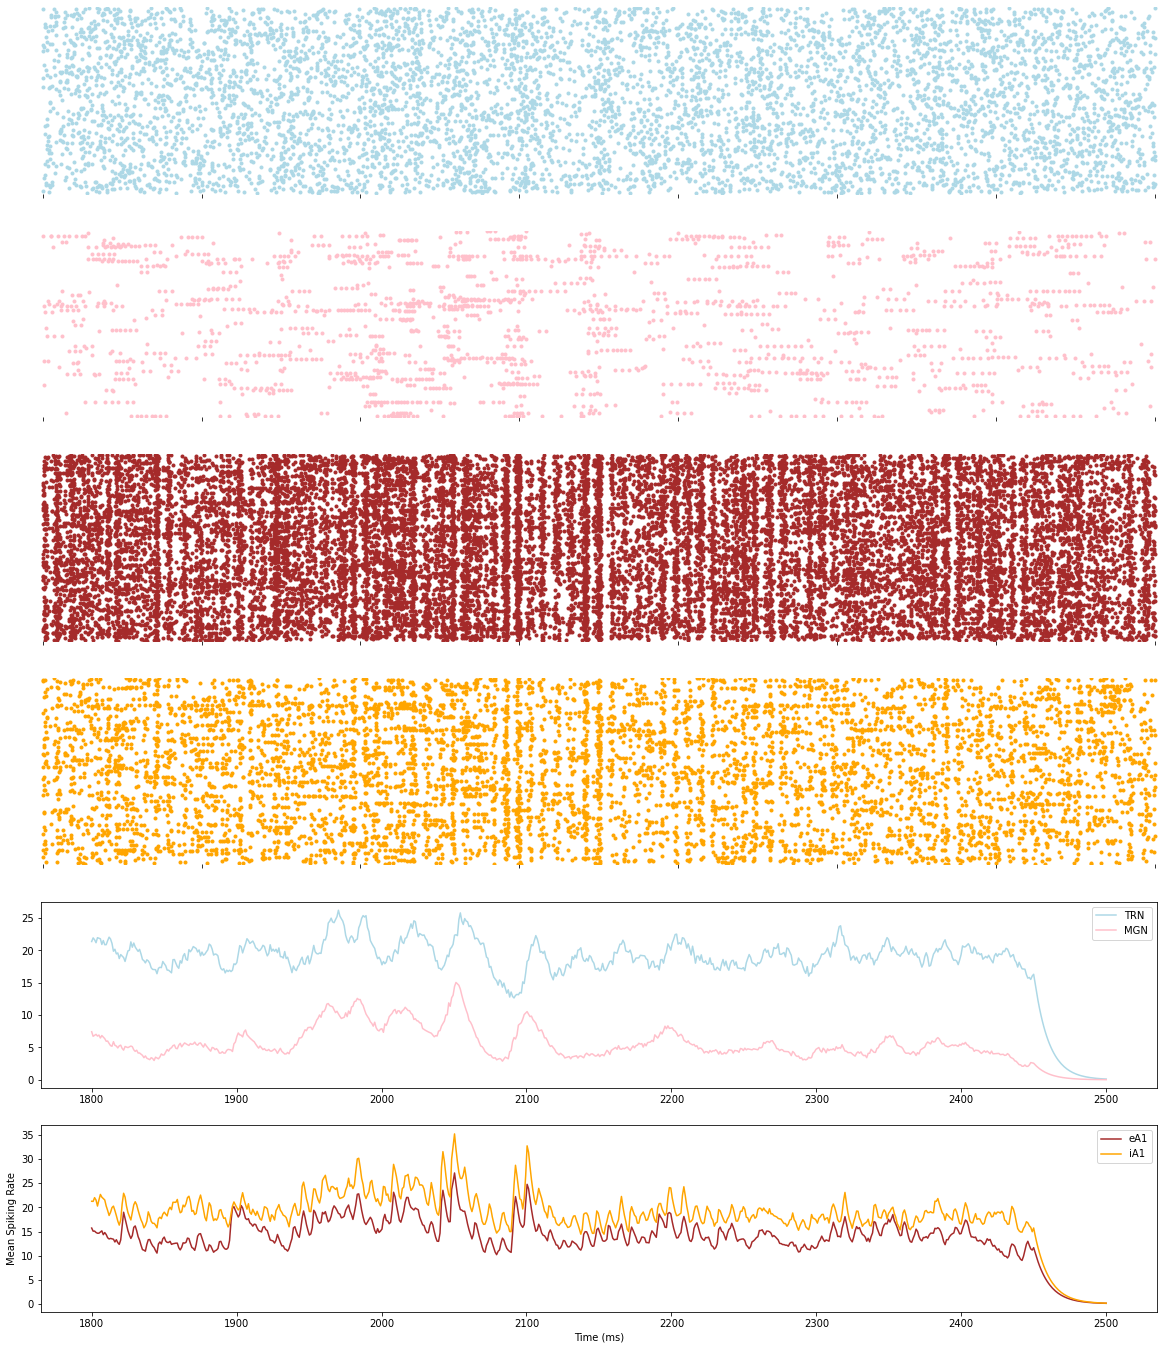

In [1317]:
pth = "demyelination/data/highergamma/activity/"
f = ['spk_highergamma_scale_w=30.0_gamma_th=40.0_nuX_aone=30.0_gamma_aone=15.0_wX_TRN=1.4']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1800
tstop = 2500
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='TRN', c='lightblue')

x, y = smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')

x, y = smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

MGN MEAN SPIKING RATE:  7.616 20.04 7.871
eA1 MEAN SPIKING RATE:  10.652333333333335 16.48 10.8015
eA1 PEARSON COEFF:  0.0009228664467554246 0.03855611778853234 0.0050762831638283094
MGN PEARSON COEFF:  -0.00435707347192167 0.07933783671527186 0.0017914436448082953


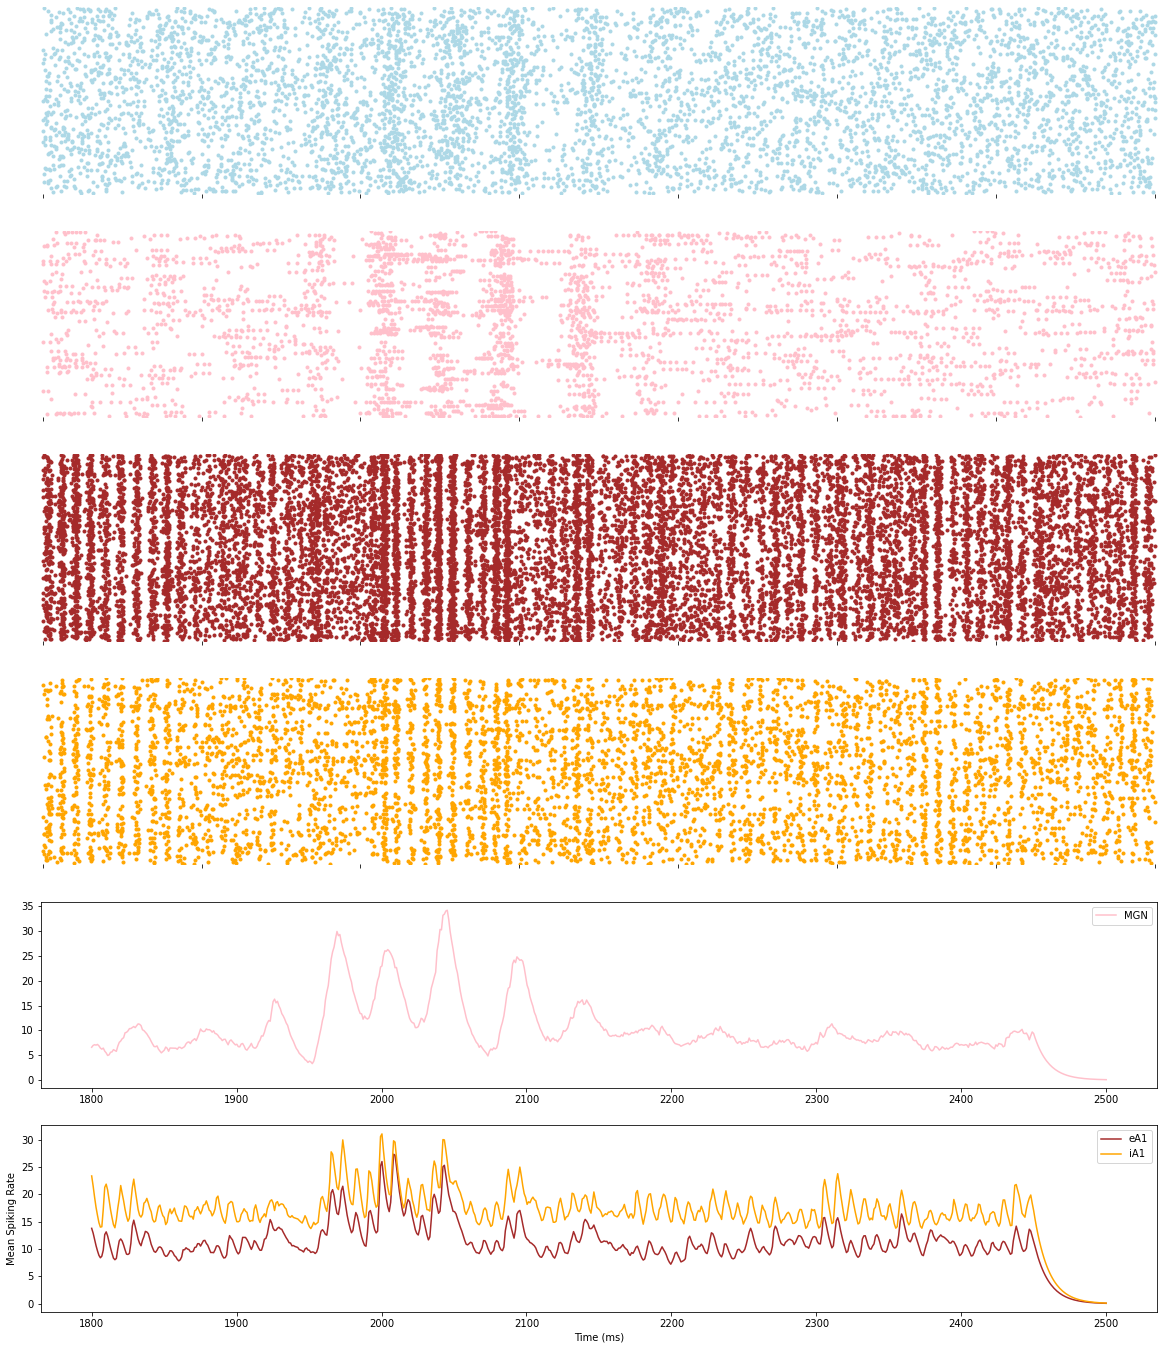

In [1504]:
pth = "demyelination/data/highergamma/activity/"
#f = ['spk_highergamma_scale_w=10.0_gamma_th=20.0_nuX_aone=25.0_gamma_aone=9.0_nuX_th=20.0'] good activity levels
f = ['spk_highergamma_scale_w=10.0_gamma_th=20.0_nuX_aone=25.0_gamma_aone=9.0_nuX_th=20.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1800
tstop = 2500
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
#ax[5].plot(x, y, label='TRN', c='lightblue')

x, y = smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')

x, y = smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

## Tonotopic

MGN MEAN SPIKING RATE:  6.672 7.94 6.906
eA1 MEAN SPIKING RATE:  8.36 8.995 8.2745
eA1 PEARSON COEFF:  0.0033785667853422755 0.007779550338149682 -0.0010405631939443417
MGN PEARSON COEFF:  0.005202327942543888 -0.0018532783319309871 0.002877631720357013


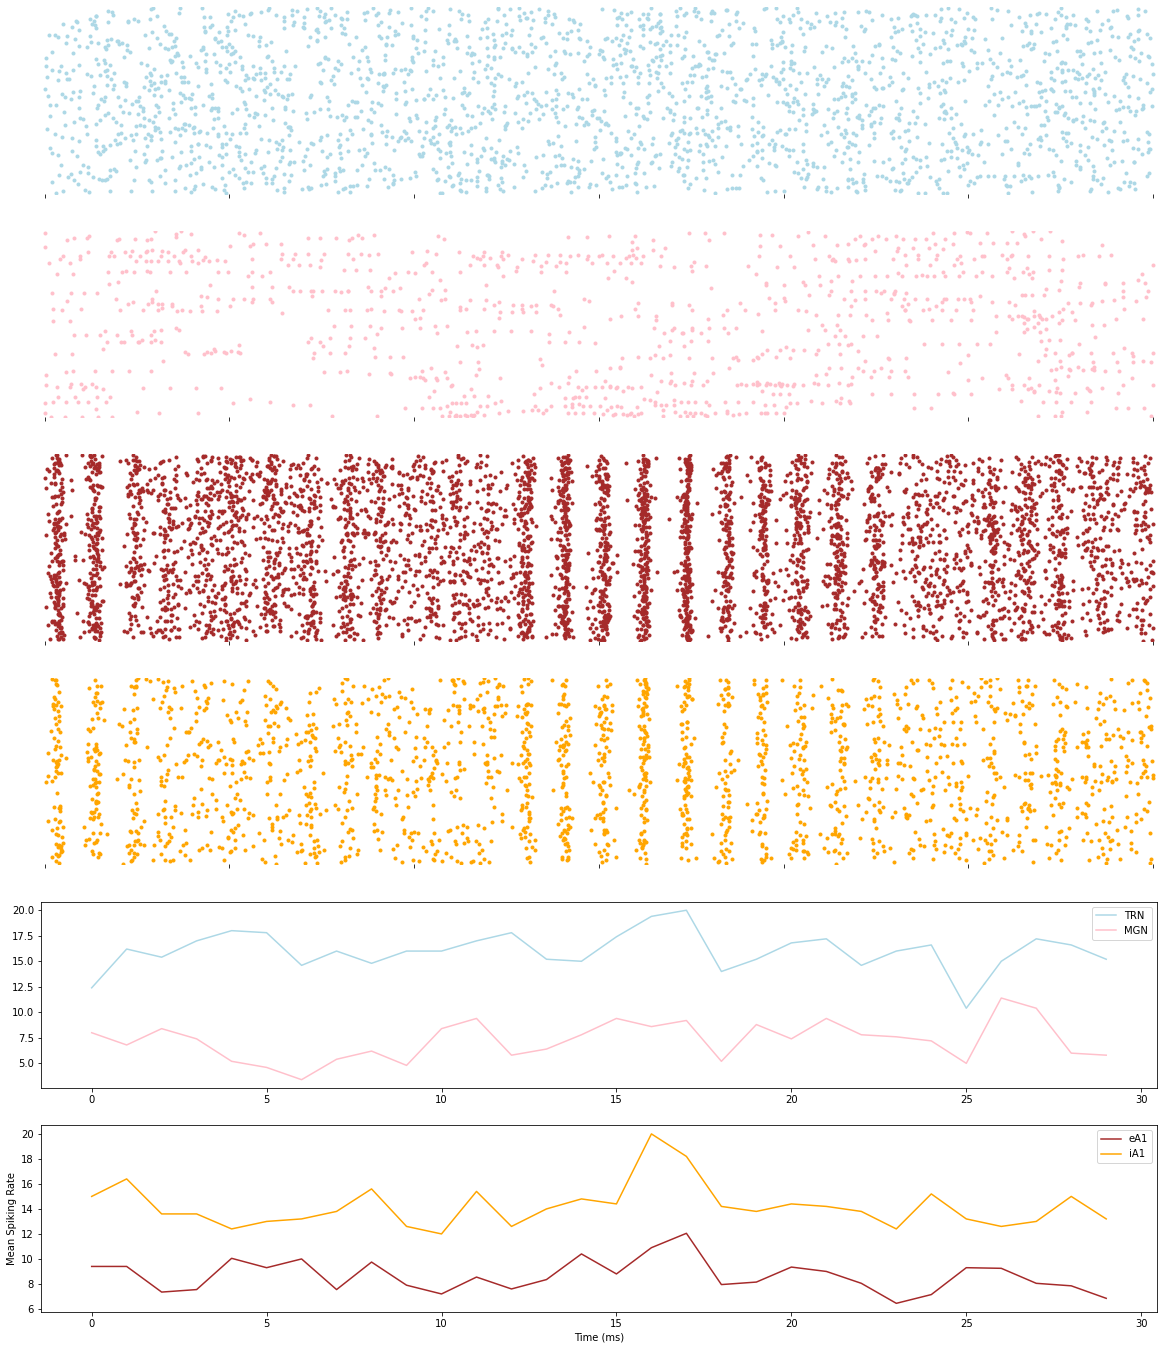

In [1803]:
pth = "demyelination/data/mgn20hz-tonotopic/activity/"
#f = ['spk_highergamma_scale_w=10.0_gamma_th=20.0_nuX_aone=25.0_gamma_aone=9.0_nuX_th=20.0'] good activity levels
f = ['spk_mgn20hz-tonotopic_w_th_stimscale=17.0_scale_w=1.0_stim_dur=100.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1900
tstop = 2200
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
#ax[5].plot(x, y, label='TRN', c='lightblue')
ax[4].plot(p.spikeobj['TRN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='TRN', c='lightblue')

x, y = smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
# ax[4].plot(x, y, label='MGN', c='pink')
ax[4].plot(p.spikeobj['MGN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='MGN', c='pink')

x, y = smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
# ax[5].plot(x, y, label='eA1', c='brown')
ax[5].plot(p.spikeobj['eA1'].time_slice(tstart, tstop).firing_rate(10, average=True), label='eA1', c='brown')

x, y = smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
# ax[5].plot(x, y, label='iA1', c='orange')
ax[5].plot(p.spikeobj['iA1'].time_slice(tstart, tstop).firing_rate(10, average=True), label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

In [1836]:
files = pipeline.readfiles("demyelination/data/mgn20hz-tonotopic/activity/");
df = preparedf(files);

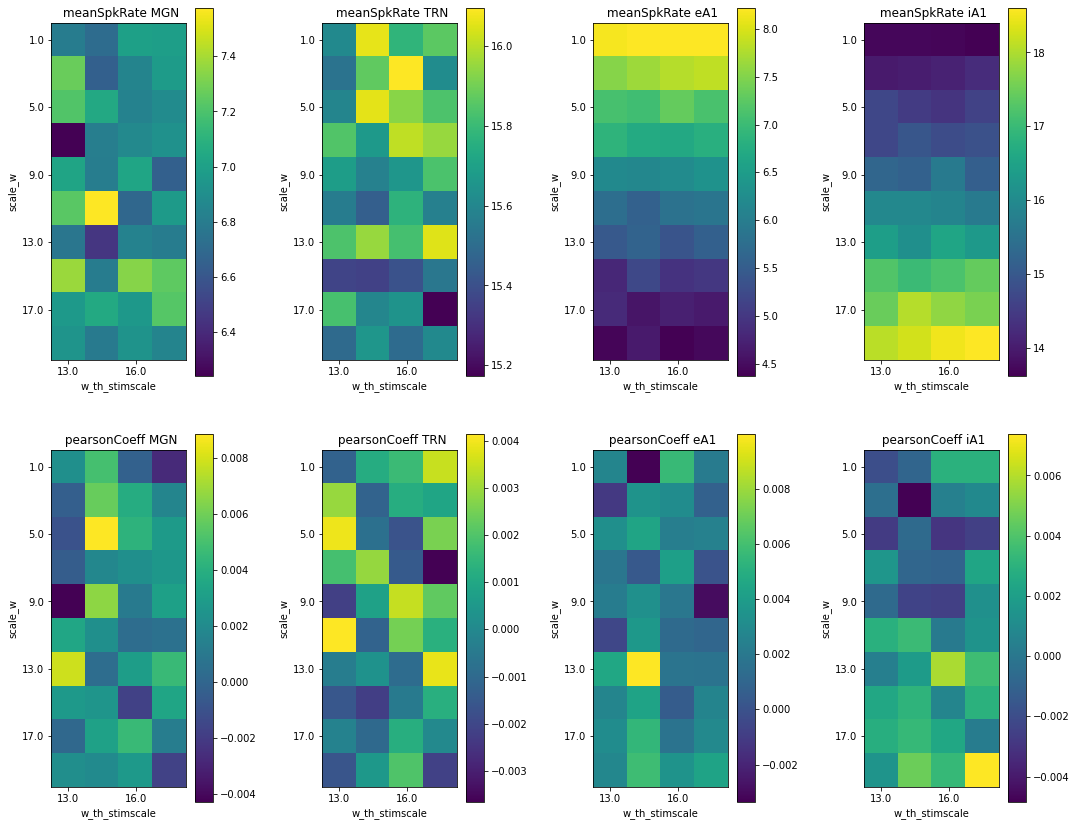

In [1652]:
fig, ax = plt.subplots(nrows=2, ncols=4)

fig.set_size_inches(15, 12)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

# dfFilter = df.wX_TRN < 1.6
dfFilter = [True] * df.shape[0]

varone = "scale_w"
vartwo = "w_th_stimscale"

makesubplot(df[dfFilter], fig, ax[0], "meanSpkRate", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

makesubplot(df[dfFilter], fig, ax[1], "pearsonCoeff", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

# makesubplot(df[dfFilter], fig, ax[2], "cvIsi", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

# makesubplot(df[dfFilter], fig, ax[3], "meanBurstSpikePercentageCerina", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

# makesubplot(df[dfFilter], fig, ax[4], "meanBurstSpikePercentageMIT", varone, vartwo, ["MGN", "TRN", "eA1", "iA1"])

fig.tight_layout()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/adaptation-aone_winputaone=15.pdf")

In [1829]:
# dir(p.spikeobj['MGN'])
p.spikeobj['MGN'].id_slice(np.arange(1, 10)).mean_rate()

6.584098898507389

In [1706]:
def subpop_firingrate(spk_obj, subpopulation, neuron_range, timeslice):
    leng = []
    for x in range(neuron_range[0], neuron_range[1]):
        leng.append(
            len(spk_obj.spikeobj[subpopulation].spiketrains[x].time_slice(timeslice[0], timeslice[1]).spike_times)
        )
    
    return np.mean(leng) * 1000 / (timeslice[1] - timeslice[0])

In [1806]:
subpop_firingrate(p, 'MGN', (1, 101), (1800, 2000)), subpop_firingrate(p, 'MGN', (1, 101), (2000, 2100)), subpop_firingrate(p, 'MGN', (1, 101), (2500, 2800))

(6.05, 16.5, 6.033333333333333)

In [1795]:
def stimanalysis(dataobjs):
    parts = ('MGN', 'eA1')
    timeframes = ()
    
    df = pd.DataFrame()

    for part in parts:
        for data in dataobjs:
            neuron_idx_start = int (list(data.spikeobj[part].spiketrains.keys())[0])
            stim_neuron_idx = int (len(data.spikeobj[part].spiketrains.keys()) * 1/5) +neuron_idx_start
            neuron_idx_end = int (list(data.spikeobj[part].spiketrains.keys())[-1])
            
            tmp = data.params
            tmp = tmp.update({
                "brainPart" : part,
                "pre_stim_meanrate" : subpop_firingrate(data, part, (neuron_idx_start, stim_neuron_idx), (1800, 2000)),
                "peri_stim_meanrate" : subpop_firingrate(data, part, (neuron_idx_start, stim_neuron_idx), (2000, 2100)),
                "post_stim_meanrate" : subpop_firingrate(data, part, (neuron_idx_start, stim_neuron_idx), (2200, 2600)),
                
                "pre_nonstim_meanrate" : subpop_firingrate(data, part, (stim_neuron_idx, neuron_idx_end), (1800, 2000)),
                "peri_nonstim_meanrate" : subpop_firingrate(data, part, (stim_neuron_idx, neuron_idx_end), (2000, 2100)),
                "post_nonstim_meanrate" : subpop_firingrate(data, part, (stim_neuron_idx, neuron_idx_end), (2200, 2600))
            })
            df = df.append(data.params, ignore_index=True)

    return df

In [1837]:
stimdf = stimanalysis(files);

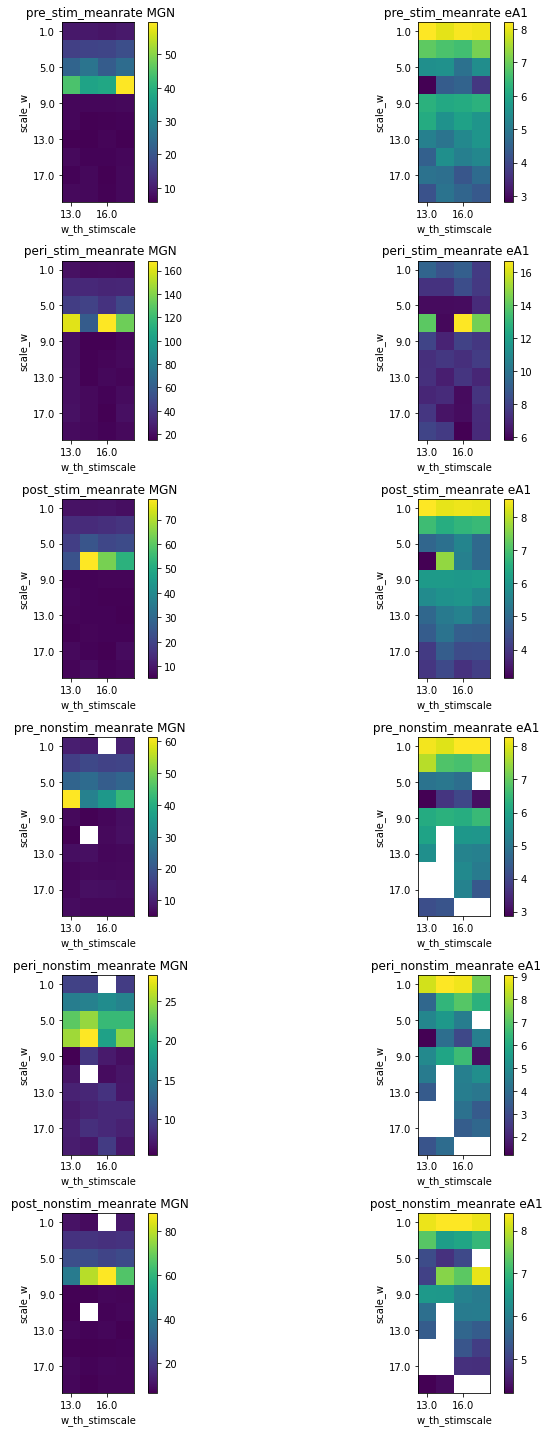

In [1838]:
fig, ax = plt.subplots(nrows=6, ncols=2)

fig.set_size_inches(10, 20)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

# dfFilter = df.wX_TRN < 1.6
dfFilter = [True] * stimdf.shape[0]

varone = "scale_w"
vartwo = "w_th_stimscale"

makesubplot(stimdf[dfFilter], fig, ax[0], "pre_stim_meanrate", varone, vartwo, ["MGN", "eA1"])

makesubplot(stimdf[dfFilter], fig, ax[1], "peri_stim_meanrate", varone, vartwo, ["MGN", "eA1"])

makesubplot(stimdf[dfFilter], fig, ax[2], "post_stim_meanrate", varone, vartwo, ["MGN", "eA1"])

makesubplot(stimdf[dfFilter], fig, ax[3], "pre_nonstim_meanrate", varone, vartwo, ["MGN", "eA1"])

makesubplot(stimdf[dfFilter], fig, ax[4], "peri_nonstim_meanrate", varone, vartwo, ["MGN", "eA1"])

makesubplot(stimdf[dfFilter], fig, ax[5], "post_nonstim_meanrate", varone, vartwo, ["MGN", "eA1"])

fig.tight_layout()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/adaptation-aone_winputaone=15.pdf")

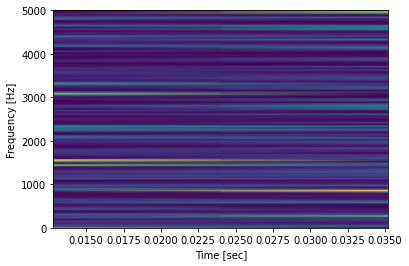

In [1817]:
from scipy import signal
from scipy.fft import fftshift

f, t, Sxx = signal.spectrogram(
    p.spikeobj['eA1'].firing_rate(10, average=True), \
    10e3)

# colorbar()

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Historic Results and Notes

**14 June 2022**

Experiment `adaptation-aone` sought to reach 10Hz of activity in the eA1 with 10pc connectivity. The max activity found was 6Hz (with w_input_aone, nuX and gamma set to 10, 15 and 2, respectively) so a higher nuX (from 5 - 20) and w_input_aone (from 10-15) was used in the next experiment.

Experiment `adaptation-aone-nuxweight` <br />
The desired acitivity levels were found for values of 20, 9, 15 nuX_aone, gamma_aone, w_input_aone respectively.

`adaptation-thl` <br />
weight of 1. and nuX of 18, 19 or 20 seems to give us desired results. a gamma from 10 to 14 has no bearing.

`adaptation-thl-stim` <br />
spk_adaptation-thl-stim_T=0_nuX_th=19_gamma_th=20_wX_TRN=1.3000000000000003 gives the best results in terms of supression and activity, however, there is no oscillation.

**20 June 2022**

`adaptation-thl-widerange` <br />
After lack of success in finding oscillations, a wider range of params was tried for more parameters. Appartently, it makes sense to hold on the the parameters found in `adaptation-thl-stim` and explore, wMGN, sigma_MGN and sigma_TRN more.

`adaptation-thl-wgmSigma` <br />
A wMGN of 1.4, a sigma_MGN of 0.2 and a sigma_TRN of 0.2 gives desirable results. It is worthwhile to look at higher wMGN values, therefore the next experiment will do that. It can be foreseen that this will lead to higher and lower activities in the TRN and MGN respectively.

`adaptation-thl-wgm` <br />
A wMGN of 2.2 gives us the desired activity. A higher wMGN leads to the second oscillation peak too high. However, the mean activity of the MGN is 8 Hz (2 less than the desired 10).

`adaptation-thl-mgnactivity` <br />
The decision is to stick to nuX_th = 19 and gamma_th = 20

`adaptation-fullmodel-verification` <br />
An experiment which simulates both the Thalamus and the Cortex, but without any connectivity between them to ensure accurate import of the code.

`adaptation-fullmodel-first` <br />
Now the connectivity has been added. It works right of the bat, but the connection from the mgn to the ctx are 20% of all the connectivity in the ctx. We are aiming for 6% (Destexhe).

`adaptation-fullmodel-epsilonmgnctx` <br />
Values of 0.05, 0.026 and 0.013 have been tried for epsilon_mgn_ctx.

`adaptation-thl-burstprob` <br />
Hundred rounds of the final params for the Thalamus to compute pre and post burst probability.

**30 July 2022 - EPSP Focused Experiments**

`fullmodel-sameepsp` <br />
An experiment to explore different nuX values for the A1 and the Thalamus such that the EPSP of all the connections is 0.25mV. It was found that a nuX_aone of 14 is good but a higher wxTRN is needed to have higher activity in the TRN.

`fullmodel-highepsp` <br />
An experiment to explore different nuX values for the A1 and the Thalamus such that the EPSP of all the connections is high.

`sameepsp-higherwxtrn` <br />
A wx_TRN of 1.6 is correct. Multiple values of nuX_th are acceptable.

`nonhomg-eps-wgh` <br />
We decided to scale the probability and weight of the connection from the MGN to the CTX. Values which give desired results are: `nuX_th=20`, `wX_TRN=1.3`, `scale_w=4.`, `scale_eps=2.` and `nuX_aone=25.`.


In [1820]:
files2 = pipeline.readfiles("demyelination/data/adaptation-thl-mgnactivity/activity/");
df = preparedf(files2);

In [1830]:
df.head()

nuX_th  gamma_th brainPart  meanSpkRate  pearsonCoeff  cvIsi
0    19.0      34.5       MGN        8.412      0.042913    NaN
1    21.0      34.5       MGN        7.544      0.061715    NaN
2    27.0      18.0       MGN        6.164      0.048091    NaN
3    25.0      34.0       MGN        5.598      0.054143    NaN
4    19.0      33.5       MGN        8.334      0.072350    NaN

In [1832]:
? makesubplot

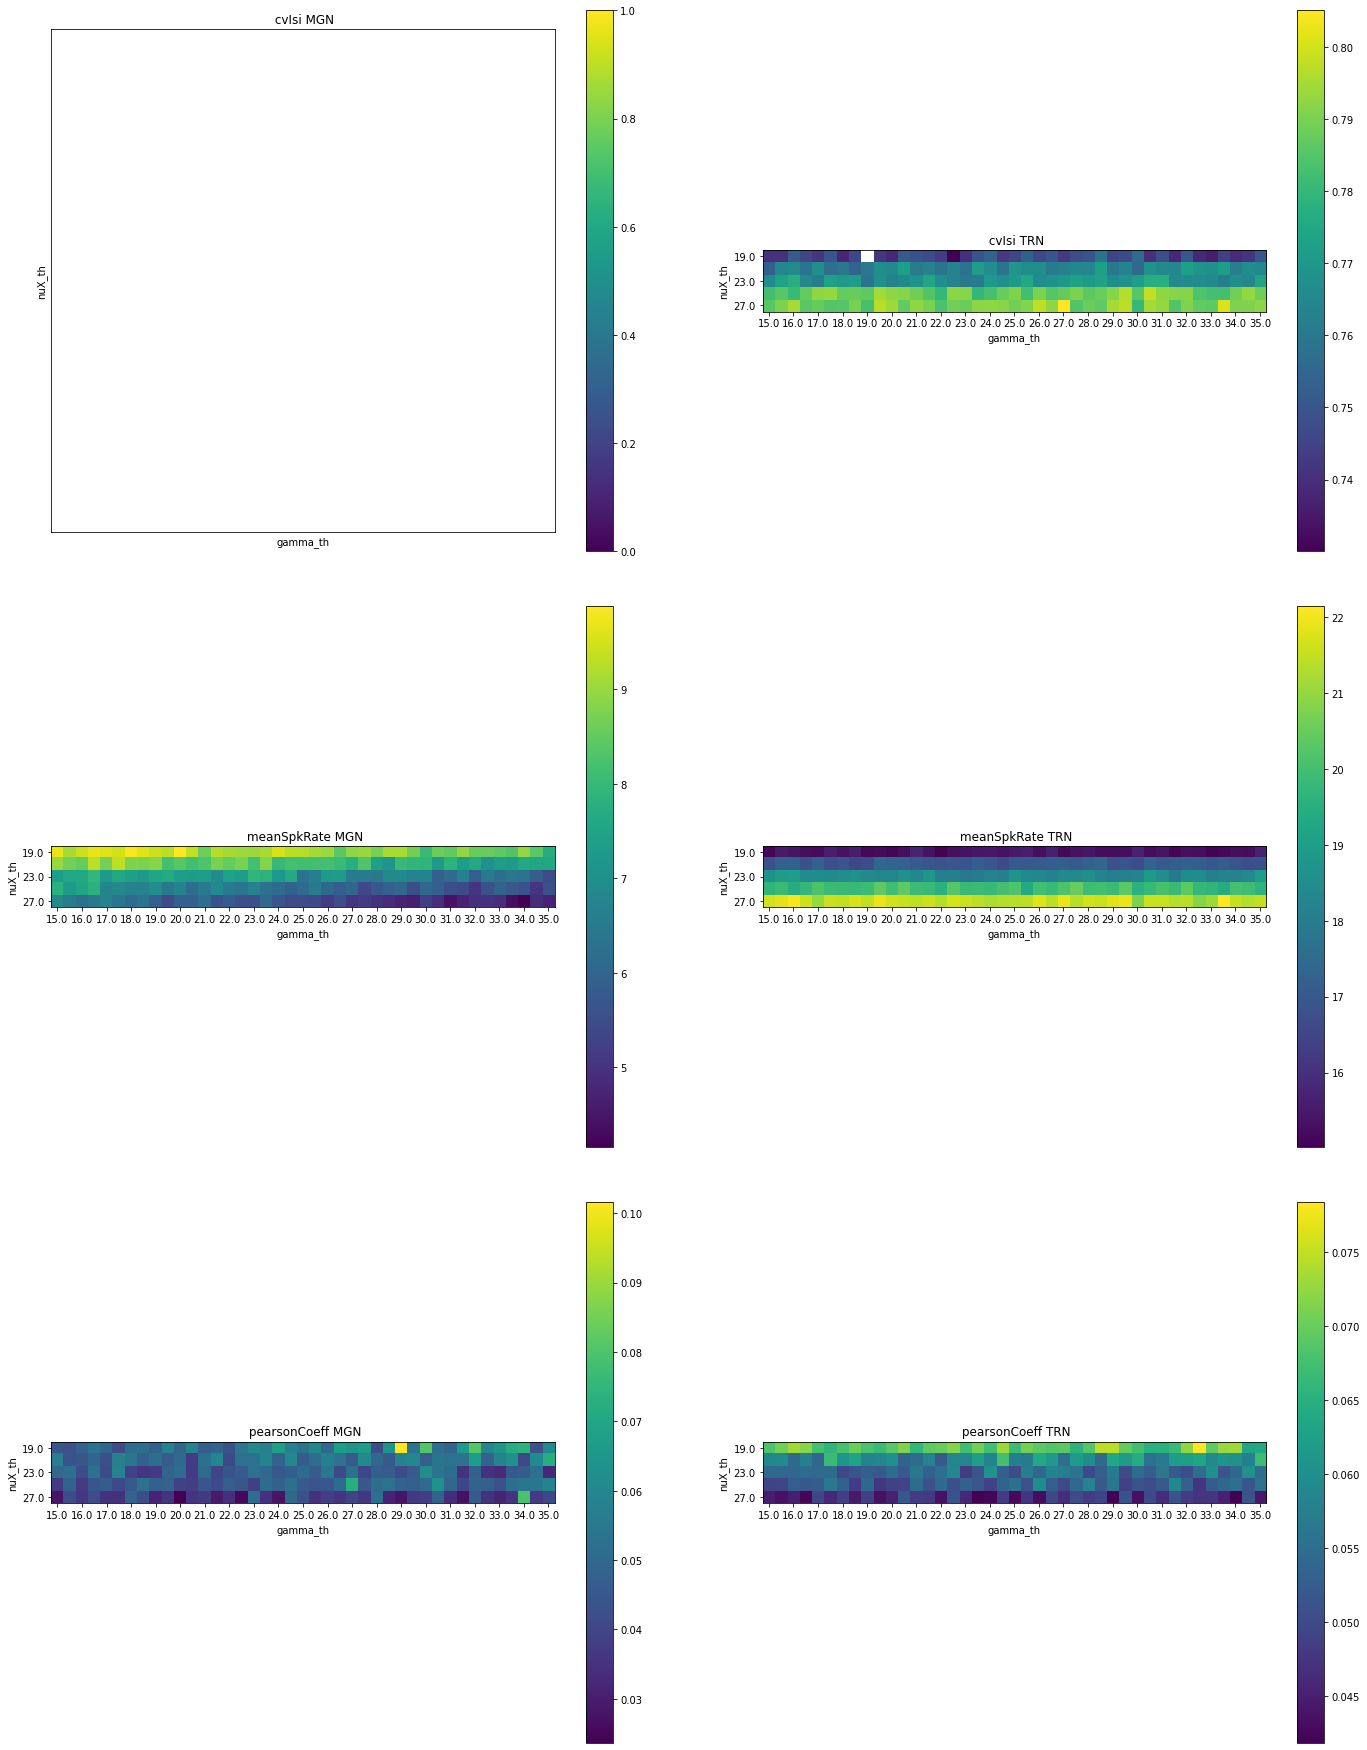

In [1835]:
fig, ax = plt.subplots(nrows=3, ncols=2)

fig.set_size_inches(20, 25)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

#dfFilter = df.w_input_aone == 15
dfFilter = [True] * df.shape[0]

varone = "nuX_th"
vartwo = "gamma_th"
parts = ["MGN", "TRN"]

makesubplot(df[dfFilter], fig, ax[0], "cvIsi", varone, vartwo, parts)

makesubplot(df[dfFilter], fig, ax[1], "meanSpkRate", varone, vartwo, parts)

makesubplot(df[dfFilter], fig, ax[2], "pearsonCoeff", varone, vartwo, parts)

#makesubplot(df[dfFilter], fig, ax[3], "meanBurstSpikePercentageCerina", varone, vartwo, parts)

#makesubplot(df[dfFilter], fig, ax[4], "meanBurstSpikePercentageMIT", varone, vartwo, parts)

fig.tight_layout()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/adaptation-aone_winputaone=15.pdf")